In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importing the necessary lib
import pandas as pd
import seaborn as sns
import numpy as np
import sqlite3
import os
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix,classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,KFold
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer,one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, BatchNormalization,concatenate,Flatten,MaxPool2D,Embedding,Dense,Dropout,MaxPooling2D,Reshape,BatchNormalization
from keras.models import Sequential
from keras import Model,Input
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Conv1D
import keras.backend as k
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,f1_score,log_loss,recall_score,classification_report
import tensorflow as tf
from keras.callbacks import Callback, EarlyStopping
from time import time
from scipy.sparse import hstack
from tensorflow.python.keras.callbacks import TensorBoard
import pickle
from keras.optimizers import Adam,SGD,RMSprop
from keras.initializers import RandomUniform,he_uniform,glorot_normal
from keras.regularizers import l1
from keras.models import Sequential
from keras.layers import LSTM,BatchNormalization
from tensorflow.keras.layers import Dense, Dropout
import datetime
from prettytable import PrettyTable
from hyperopt import Trials, STATUS_OK, tpe
!pip install hyperas
from hyperas import optim
from hyperas.distributions import choice, uniform,pchoice
from keras.utils import to_categorical
from keras.regularizers import l1
import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.8 MB/s eta 0:00:00


In [3]:
#Reading the train, test and CV data
train = pd.read_csv('/content/drive/MyDrive/TEP Dataset/train.csv')
cv = pd.read_csv("/content/drive/MyDrive/TEP Dataset/cv.csv")
test = pd.read_csv("/content/drive/MyDrive/TEP Dataset/test.csv")
train.head()
print(train.shape)

(260000, 56)


In [125]:
# Removing faults 3, 9, and 15
tr = train.drop(train[(train.faultNumber == 3) | (train.faultNumber == 9) | (train.faultNumber == 15)].index).reset_index()
ts = test.drop(test[(test.faultNumber == 3) | (test.faultNumber == 9) | (test.faultNumber == 15)].index).reset_index()
cv_ = cv.drop(cv[(cv.faultNumber == 3) | (cv.faultNumber == 9) | (cv.faultNumber == 15)].index).reset_index()

In [126]:
# Map fault numbers to a new continuous range
mapping = {0:0, 1:1, 2:2, 4:3, 5:4, 6:5, 7:6, 8:7, 10:8, 11:9, 12:10, 13:11, 14:12, 16:13, 17:14, 18:15, 19:16, 20:17}
tr['mappedFaultNumber'] = tr['faultNumber'].map(mapping)
ts['mappedFaultNumber'] = ts['faultNumber'].map(mapping)
cv_['mappedFaultNumber'] = cv_['faultNumber'].map(mapping)

In [127]:
 # Column names to drop
columns_to_drop = tr.columns[27:46]

# Drop the columns from the dataframes
tr.drop(columns_to_drop, axis=1, inplace=True)
ts.drop(columns_to_drop, axis=1, inplace=True)
cv_.drop(columns_to_drop, axis=1, inplace=True)


In [128]:
tr.head()

,index,Unnamed: 0,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,...,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11,mappedFaultNumber
0,0,0,0.0,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,...,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447,0
1,1,1,0.0,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,...,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194,0
2,2,2,0.0,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,...,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530,0
3,3,3,0.0,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,...,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089,0
4,4,4,0.0,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,...,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461,0


In [129]:

def SlidingWindow(df, w, s):
    X = []
    Y = []
    for i in range(0, len(df)-w+1, s):
        x = np.array(df.iloc[i:i+w, 5:-1])  # Selecting features from xmeas_1 to xmv_11
        y = df.iloc[i+w-1, -1]  # Selecting the target value (mappedFaultNumber) from the last column
        X.append(x)
        Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

# Initialize window size and step size
w = 20
s = 10

# Initialize lists for storing the data
X_train = []
Y_train = []

# Adjust the loop for the correct number of simulation runs
for j in range(0, 18):  # Iterating correctly from 0 to 17
    max_runs = 40 if j == 0 else 25  # Assuming faultNumber 0 is fault-free
    for i in range(1, max_runs + 1):  # Iterate over the correct number of simulation runs
        df = tr[(tr['mappedFaultNumber'] == j) & (tr['simulationRun'] == i)]
        x_temp, y_temp = SlidingWindow(df, w, s)
        X_train.extend(x_temp)
        Y_train.extend(y_temp)

# Convert X and Y to numpy arrays and reshape X for LSTM
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_train = X_train.reshape(-1, w, X_train.shape[-1])

X_train.shape, Y_train.shape


((21935, 20, 33), (21935,))

In [130]:
print(Y_train.shape)

(21935,)


In [131]:
print(tr.head())

   index  Unnamed: 0  faultNumber  simulationRun  sample  xmeas_1  xmeas_2  \
0      0           0          0.0            1.0       1  0.25038   3674.0   
1      1           1          0.0            1.0       2  0.25109   3659.4   
2      2           2          0.0            1.0       3  0.25038   3660.3   
3      3           3          0.0            1.0       4  0.24977   3661.3   
4      4           4          0.0            1.0       5  0.29405   3679.0   

   xmeas_3  xmeas_4  xmeas_5  ...   xmv_3   xmv_4   xmv_5   xmv_6   xmv_7  \
0   4529.0   9.2320   26.889  ...  24.657  62.544  22.137  39.935  42.323   
1   4556.6   9.4264   26.721  ...  24.588  59.259  22.084  40.176  38.554   
2   4477.8   9.4426   26.875  ...  24.666  61.275  22.380  40.244  38.990   
3   4512.1   9.4776   26.758  ...  24.725  59.856  22.277  40.257  38.072   
4   4497.0   9.3381   26.889  ...  28.797  60.717  21.947  39.144  41.955   

    xmv_8   xmv_9  xmv_10  xmv_11  mappedFaultNumber  
0  47.757  47

In [132]:
# Initialize a StandardScaler object
sc = StandardScaler()

# Filter the DataFrame to only include data from the first simulation run
reduced_data = tr[tr['faultNumber']==0]
# Select the rows from the reduced dataset that have faultNumber equal to 0, and extract the feature values
fault_free = reduced_data[(reduced_data['faultNumber'] == 0)].iloc[:, 5:-1]

# Fit the StandardScaler object to the feature values of the fault-free data
sc.fit(fault_free)

StandardScaler()

In [133]:
X_train_sc = sc.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

In [134]:
print(X_train_sc.shape)

(21935, 20, 33)


In [135]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Input, Dense, LSTM,Conv2D,Conv1D,Flatten,MaxPooling2D,GlobalAveragePooling2D,Dropout,Bidirectional
from keras.models import Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Dropout, Input

In [136]:
# Create an instance of the OneHotEncoder with the 'sparse' parameter set to False
enc = OneHotEncoder(sparse=False)

# Fit the OneHotEncoder to the target values Y, which must be reshaped to have a single column
enc.fit(Y_train.reshape(-1, 1))

# Transform the target values Y to one-hot encoded form, by applying the OneHotEncoder to the reshaped Y array
Y_train_enc = enc.transform(Y_train.reshape(-1, 1))

In [137]:
print(Y_train_enc.shape)

(21935, 18)


In [138]:
## Now Prepare CV and Test Data Set

In [139]:


def SlidingWindow(df, w, s):
    X = []
    Y = []
    for i in range(0, len(df)-w+1, s):
        x = np.array(df.iloc[i:i+w, 5:-1])  # Selecting features from xmeas_1 to xmv_11
        y = df.iloc[i+w-1, -1]  # Selecting the target value (mappedFaultNumber) from the last column
        X.append(x)
        Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

# Initialize window size and step size
w = 20
s = 10

# Initialize lists for storing the data
X_test = []
Y_test = []

# Adjust the loop for the correct number of simulation runs
for j in range(0, 18):  # Iterating correctly from 0 to 18
    max_runs = 3 if j == 0 else 10  # Assuming faultNumber 0 is fault-free
    for i in range(1, max_runs + 1):  # Iterate over the correct number of simulation runs
        df = ts[(ts['mappedFaultNumber'] == j) & (ts['simulationRun'] == i)]
        x_temp, y_temp = SlidingWindow(df, w, s)
        X_test.extend(x_temp)
        Y_test.extend(y_temp)

# Convert X and Y to numpy arrays and reshape X for LSTM
X_test = np.array(X_test)
Y_test = np.array(Y_test)
X_test = X_test.reshape(-1, w, X_test.shape[-1])

X_test.shape, Y_test.shape


((8187, 20, 33), (8187,))

In [140]:
print(cv_.head())

   index  Unnamed: 0  faultNumber  simulationRun  sample  xmeas_1  xmeas_2  \
0      0       20000          0.0           41.0       1  0.24688   3647.9   
1      1       20001          0.0           41.0       2  0.25000   3674.5   
2      2       20002          0.0           41.0       3  0.24920   3654.1   
3      3       20003          0.0           41.0       4  0.25134   3676.3   
4      4       20004          0.0           41.0       5  0.25737   3676.2   

   xmeas_3  xmeas_4  xmeas_5  ...   xmv_3   xmv_4   xmv_5   xmv_6   xmv_7  \
0   4533.6   9.4248   26.922  ...  25.002  59.902  22.471  40.327  39.962   
1   4529.1   9.2560   27.140  ...  24.695  61.624  22.421  40.185  42.975   
2   4508.9   9.1863   26.726  ...  24.782  63.532  22.156  40.091  44.833   
3   4554.6   9.3282   26.475  ...  24.571  63.426  21.658  40.113  39.402   
4   4446.9   9.2917   27.190  ...  24.805  62.954  22.301  40.527  42.334   

    xmv_8   xmv_9  xmv_10  xmv_11  mappedFaultNumber  
0  44.677  47

In [141]:


def SlidingWindow(df, w, s):
    X = []
    Y = []
    for i in range(0, len(df)-w+1, s):
        x = np.array(df.iloc[i:i+w, 5:-1])  # Selecting features from xmeas_1 to xmv_11
        y = df.iloc[i+w-1, -1]  # Selecting the target value (mappedFaultNumber) from the last column
        X.append(x)
        Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

# Initialize window size and step size
w = 20
s = 10

# Initialize lists for storing the data
X_cv = []
Y_cv = []

# Adjust the loop for the correct number of simulation runs
for j in range(0, 18):  # Iterating correctly from 0 to 18
    if j == 0:
        max_runs = 20  # Assuming faultNumber 0 is fault-free
        for i in range(41, max_runs + 41):  # Iterate over the correct number of simulation runs
            df = cv_[(cv_['mappedFaultNumber'] == j) & (cv_['simulationRun'] == i)]
            x_temp, y_temp = SlidingWindow(df, w, s)
            X_cv.extend(x_temp)
            Y_cv.extend(y_temp)
    else:
        max_runs = 10
        for i in range(26, max_runs + 26):  # Iterate over the range 26 to max_runs
            df = cv_[(cv_['mappedFaultNumber'] == j) & (cv_['simulationRun'] == i)]
            x_temp, y_temp = SlidingWindow(df, w, s)
            X_cv.extend(x_temp)
            Y_cv.extend(y_temp)


# Convert X and Y to numpy arrays and reshape X for LSTM
X_cv = np.array(X_cv)
Y_cv = np.array(Y_cv)
X_cv = X_cv.reshape(-1, w, X_cv.shape[-1])

X_cv.shape, Y_cv.shape


((8970, 20, 33), (8970,))

In [142]:
print(X_cv[0,:,-1])

[19.807 17.919 19.579 16.9   19.291 16.629 17.457 18.343 18.65  17.924
 20.155 18.812 15.903 17.382 17.416 15.328 19.123 19.999 19.95  17.681]


In [143]:
X_test_sc = sc.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [144]:
X_cv_sc = sc.transform(X_cv.reshape(-1, X_cv.shape[-1])).reshape(X_cv.shape)

In [145]:
# Create an instance of the OneHotEncoder with the 'sparse' parameter set to False
enc_1 = OneHotEncoder(sparse=False)

# Fit the OneHotEncoder to the target values Y, which must be reshaped to have a single column
enc_1.fit(Y_test.reshape(-1, 1))

# Transform the target values Y to one-hot encoded form, by applying the OneHotEncoder to the reshaped Y array
Y_test_enc = enc_1.transform(Y_test.reshape(-1, 1))

In [146]:
# Create an instance of the OneHotEncoder with the 'sparse' parameter set to False
enc_2 = OneHotEncoder(sparse=False)

# Fit the OneHotEncoder to the target values Y, which must be reshaped to have a single column
enc_2.fit(Y_cv.reshape(-1, 1))

# Transform the target values Y to one-hot encoded form, by applying the OneHotEncoder to the reshaped Y array
Y_cv_enc = enc_2.transform(Y_cv.reshape(-1, 1))

In [147]:
Y_train.shape

(21935,)

In [148]:
from keras.layers import Input, GRU, Dense, Flatten
from keras.models import Model

def classifier_model(X_train, y_train):
    # Define the input layer, expects a 3D array input
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # Define the GRU encoder part (to create a latent space representation)
    encoder = GRU(64, activation='relu', return_sequences=True)(input_layer)
    encoder = GRU(16, activation='relu')(encoder)  # This is the latent space representation

    # Flatten the output to make it suitable for dense layers
    flat_latent_space = Flatten()(encoder)

    # Define the classifier part using the flattened latent space representation
    classifier = Dense(100, activation='selu')(flat_latent_space)
    classifier = Dense(50, activation='selu')(classifier)
    outputs = Dense(y_train.shape[1], activation='softmax')(classifier)  # Output layer for classification

    # Define the classifier model
    model = Model(inputs=input_layer, outputs=outputs)

    # Compile the classifier
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model




Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 20, 33)]          0         
                                                                 
 gru_4 (GRU)                 (None, 20, 64)            19008     
                                                                 
 gru_5 (GRU)                 (None, 16)                3936      
                                                                 
 flatten_2 (Flatten)         (None, 16)                0         
                                                                 
 dense_16 (Dense)            (None, 100)               1700      
                                                                 
 dense_17 (Dense)            (None, 50)                5050      
                                                                 
 dense_18 (Dense)            (None, 18)                918 

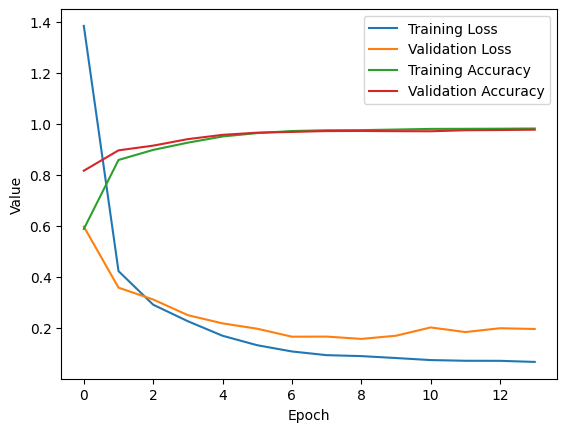

In [149]:
# Define early stopping callback to monitor validation loss and stop if it doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5)
# Create model
model = classifier_model(X_train_sc,Y_train_enc)
model.summary()
# Train the model with 20 epochs and batch size of 32, using the early stopping callback
history = model.fit(X_train_sc, Y_train_enc, epochs=200, batch_size=256, validation_data=(X_cv_sc, Y_cv_enc), callbacks=[early_stop])

# Plot the training history for loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Define custom class labels
custom_labels = ['0', '1', '2', '4', '5', '6', '7', '8', '10,','11', '12', '13', '14', '16', '17', '18', '19','20']

# Create a function to plot the confusion matrix with custom labels
def plot_confusion_matrix_1(y_true, y_pred, title):
    f, ax = plt.subplots(figsize=(15, 15))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', ax=ax,
                xticklabels=custom_labels, yticklabels=custom_labels)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_ylim(len(cm), 0)
    plt.tight_layout()
    plt.show()

    f, ax = plt.subplots(figsize=(15, 15))
    precision = confusion_matrix(y_true, y_pred, normalize='pred')
    sns.heatmap(precision, annot=True, cmap='Blues', ax=ax,
                xticklabels=custom_labels, yticklabels=custom_labels)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_ylim(len(precision), 0)
    plt.tight_layout()
    plt.show()

    f, ax = plt.subplots(figsize=(15, 15))
    recall = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(recall, annot=True, cmap='Blues', ax=ax,
                xticklabels=custom_labels, yticklabels=custom_labels)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_ylim(len(recall), 0)
    plt.tight_layout()
    plt.show()


    trace = np.diag(precision)

     # Sum of the trace (the sum of the diagonal elements of the confusion matrix) gives total true positives
    total_true_positives = np.sum(trace)

# Calculate the aggregate precision including class '0'
# Divide the total true positives by the number of classes
    aggregate_precision_including = total_true_positives / len(custom_labels)
    print(f"Aggregate Precision (including all classes): {aggregate_precision_including:.3f}")

# Calculate the aggregate precision excluding class '0'
# Subtract the true positives of class '0' from the total true positives and divide by the number of classes minus one
    aggregate_precision_excluding = (total_true_positives - trace[0]) / (len(custom_labels) - 1)
    print(f"Aggregate Precision (excluding class '0'): {aggregate_precision_excluding:.3f}")


In [151]:
y_pred = enc_1.inverse_transform(model.predict(X_test_sc, verbose=0))

In [152]:
y_true = enc_1.inverse_transform(Y_test_enc)

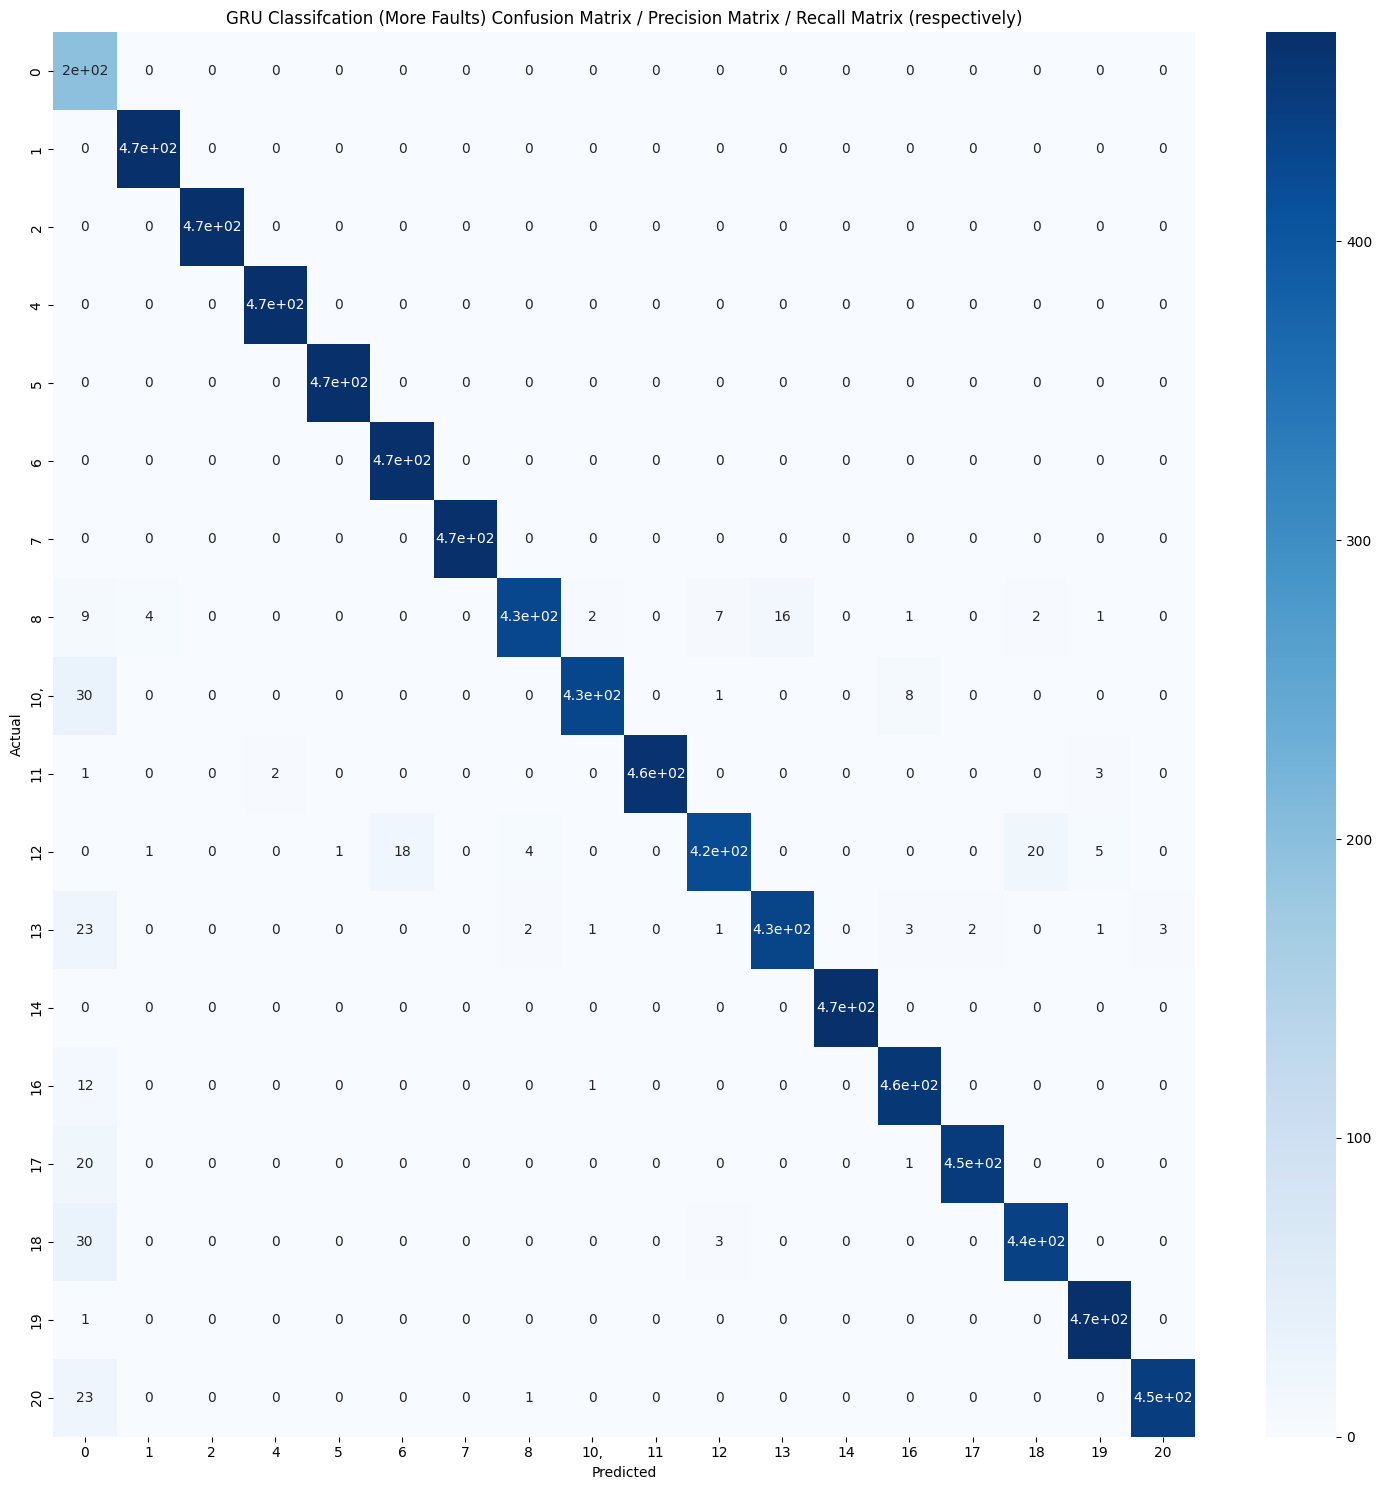

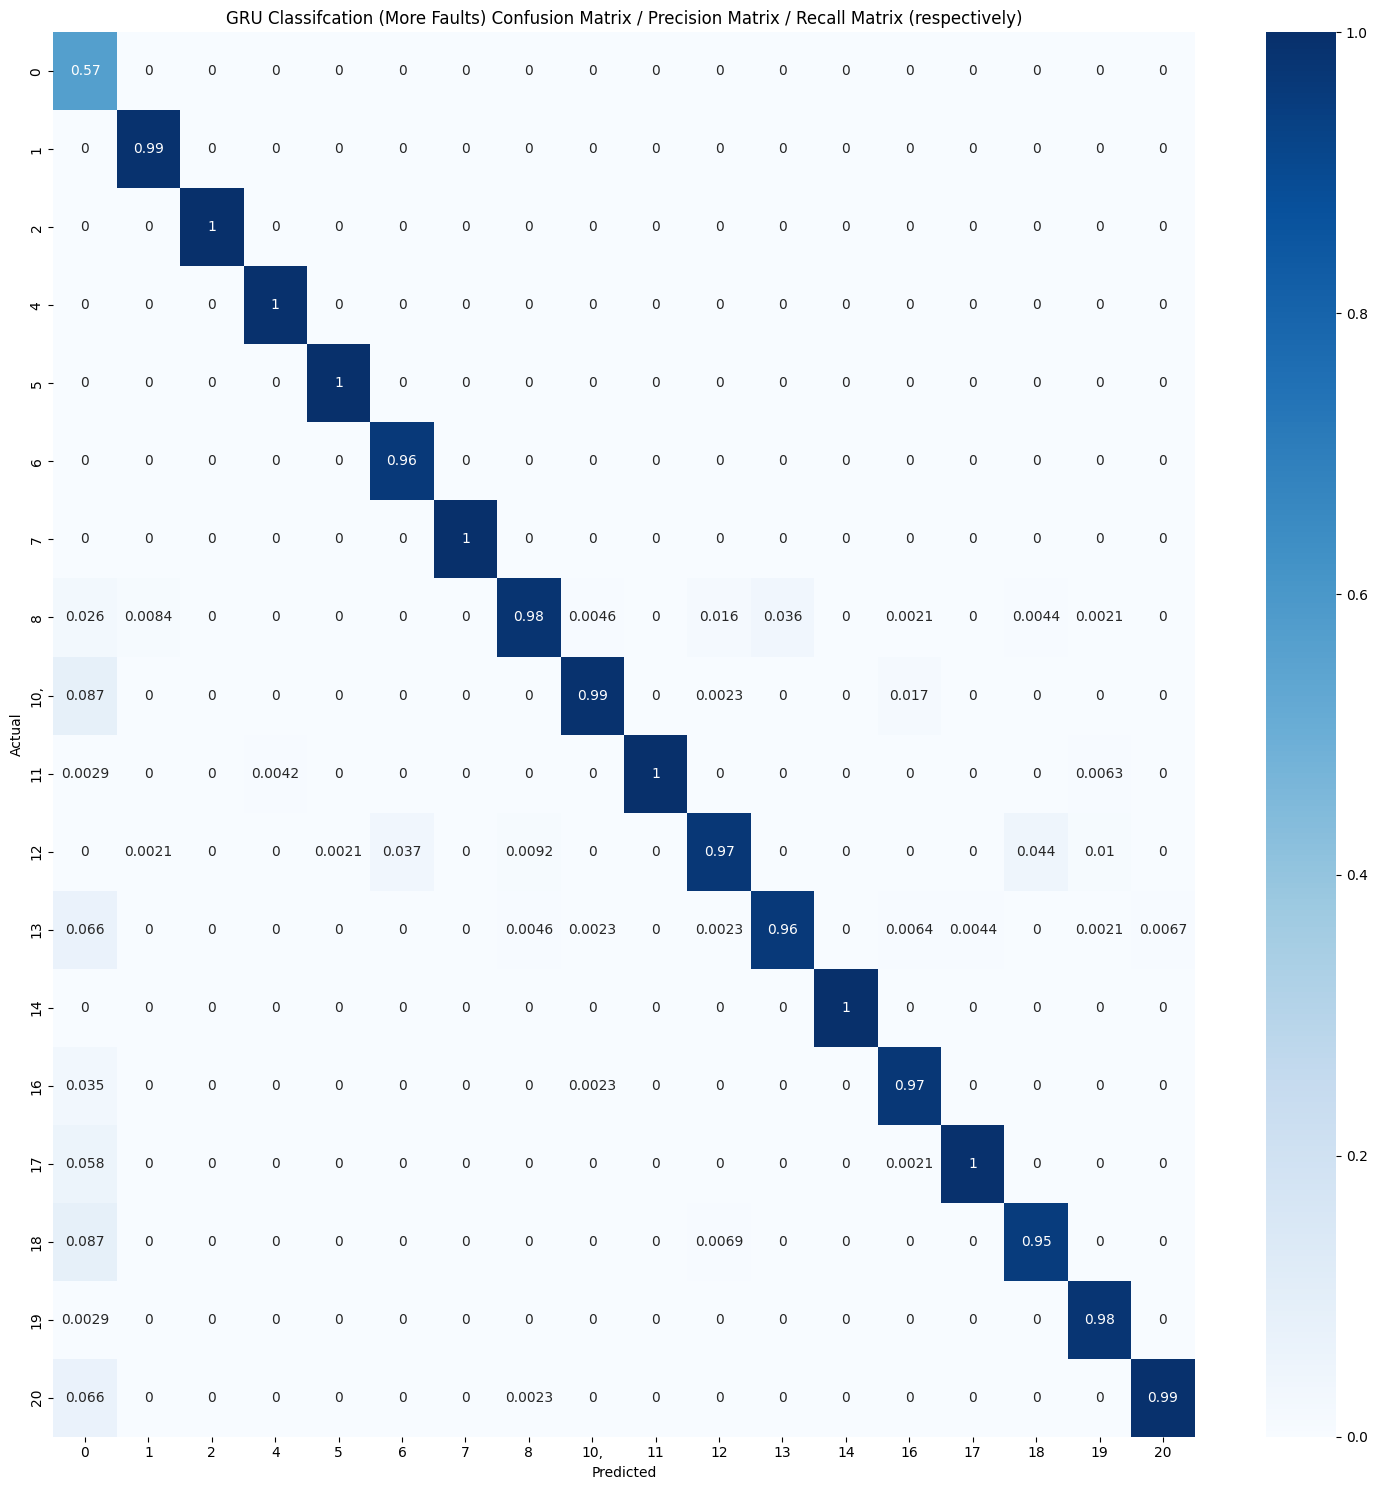

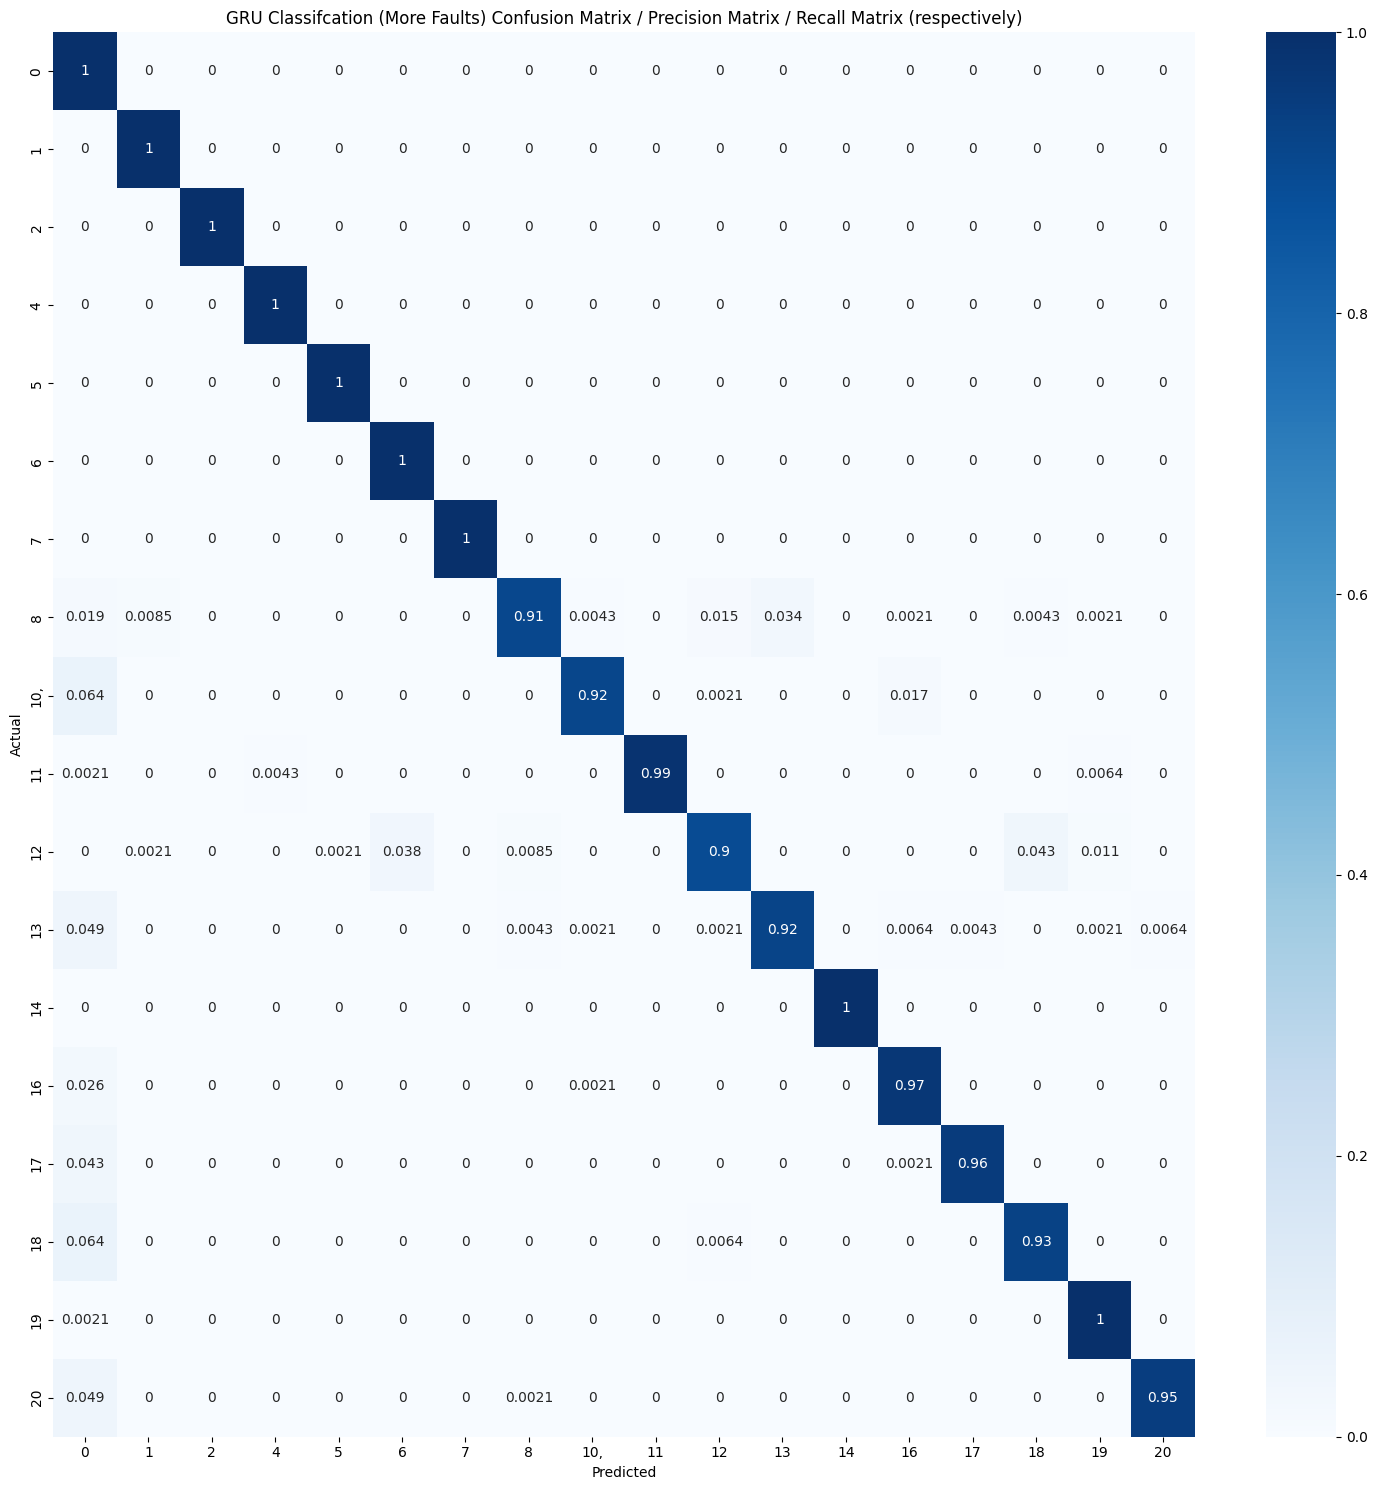

Aggregate Precision (including all classes): 0.962
Aggregate Precision (excluding class '0'): 0.985
GRU Classification (More Faults) accuracy_score: 0.9677537559545621


In [153]:
plot_confusion_matrix_1(y_true, y_pred, 'GRU Classifcation (More Faults) Confusion Matrix / Precision Matrix / Recall Matrix (respectively)')
print("GRU Classification (More Faults) accuracy_score:", accuracy_score(y_true, y_pred))


In [154]:
# Option 1: Use 'micro' average
print("GRU Classification (More Faults) f1 score micro:", f1_score(y_true, y_pred, average='micro'))

# Option 2: Use 'macro' average
print("GRU Classification (More Faults) f1 score macro:", f1_score(y_true, y_pred, average='macro'))

# Option 3: Use 'weighted' average
print("GRU Classification (More Faults) f1 score weighted:", f1_score(y_true, y_pred, average='weighted'))

# Option 4: Get F1 score for each class (No average)
print("GRU Classification (More Faults) f1 score none:", f1_score(y_true, y_pred, average=None))


GRU Classification (More Faults) f1 score micro: 0.9677537559545621
GRU Classification (More Faults) f1 score macro: 0.9618538871691881
GRU Classification (More Faults) f1 score weighted: 0.9697319515892607
GRU Classification (More Faults) f1 score none: [0.72559853 0.99470899 1.         0.99787686 0.9989373  0.98121086
 1.         0.94585635 0.95248619 0.99357602 0.9324474  0.94347826
 1.         0.97234043 0.97502714 0.94079656 0.98840885 0.97062024]


In [155]:




###############GRU Autoencoder with less faults###############





In [156]:
# Removing faults 3, 5, 8, 9, 10, 12, 15, 16, and 18.
tr_1 = train.drop(train[(train.faultNumber == 3) | (train.faultNumber == 9) | (train.faultNumber == 15) | (train.faultNumber == 5) | (train.faultNumber == 8) | (train.faultNumber == 10) | (train.faultNumber == 12) | (train.faultNumber == 16) | (train.faultNumber == 18)].index).reset_index()
ts_1 = test.drop(test[(test.faultNumber == 3) | (test.faultNumber == 9) | (test.faultNumber == 15) | (test.faultNumber == 5) | (test.faultNumber == 8) | (test.faultNumber == 10) | (test.faultNumber == 12) | (test.faultNumber == 16) | (test.faultNumber == 18)].index).reset_index()
cv_1 = cv.drop(cv[(cv.faultNumber == 3) | (cv.faultNumber == 9) | (cv.faultNumber == 15) | (cv.faultNumber == 5) | (cv.faultNumber == 8) | (cv.faultNumber == 10) | (cv.faultNumber == 12) | (cv.faultNumber == 16) | (cv.faultNumber == 18)].index).reset_index()

In [157]:
# Map fault numbers to a new continuous range
mapping = {0:0, 1:1, 2:2, 4:3, 6:4, 7:5, 11:6, 13:7, 14:8, 17:9, 19:10, 20:11}
tr_1['mappedFaultNumber'] = tr_1['faultNumber'].map(mapping)
ts_1['mappedFaultNumber'] = ts_1['faultNumber'].map(mapping)
cv_1['mappedFaultNumber'] = cv_1['faultNumber'].map(mapping)

In [158]:
 # Column names to drop
columns_to_drop = tr_1.columns[27:46]

# Drop the columns from the dataframes
tr_1.drop(columns_to_drop, axis=1, inplace=True)
ts_1.drop(columns_to_drop, axis=1, inplace=True)
cv_1.drop(columns_to_drop, axis=1, inplace=True)


In [159]:


def SlidingWindow(df, w, s):
    X = []
    Y = []
    for i in range(0, len(df)-w+1, s):
        x = np.array(df.iloc[i:i+w, 5:-1])  # Selecting features from xmeas_1 to xmv_11
        y = df.iloc[i+w-1, -1]  # Selecting the target value (mappedFaultNumber) from the last column
        X.append(x)
        Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

# Initialize window size and step size
w = 20
s = 10

# Initialize lists for storing the data
X_train = []
Y_train = []

# Adjust the loop for the correct number of simulation runs
for j in range(0, 12):  # Iterating correctly from 0 to 11
    max_runs = 40 if j == 0 else 25  # Assuming faultNumber 0 is fault-free
    for i in range(1, max_runs + 1):  # Iterate over the correct number of simulation runs
        df = tr_1[(tr_1['mappedFaultNumber'] == j) & (tr_1['simulationRun'] == i)]
        x_temp, y_temp = SlidingWindow(df, w, s)
        X_train.extend(x_temp)
        Y_train.extend(y_temp)

# Convert X and Y to numpy arrays and reshape X for LSTM
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_train = X_train.reshape(-1, w, X_train.shape[-1])

X_train.shape, Y_train.shape


((14885, 20, 33), (14885,))

In [160]:
# Initialize a StandardScaler object
sc = StandardScaler()

# Filter the DataFrame to only include data from the first simulation run
reduced_data = tr_1[tr_1['faultNumber']==0]
# Select the rows from the reduced dataset that have faultNumber equal to 0, and extract the feature values
fault_free = reduced_data[(reduced_data['faultNumber'] == 0)].iloc[:, 5:-1]

# Fit the StandardScaler object to the feature values of the fault-free data
sc.fit(fault_free)

StandardScaler()

In [161]:
X_train_sc = sc.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

In [162]:
print(X_train_sc.shape)

(14885, 20, 33)


In [163]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Input, Dense, LSTM,Conv2D,Conv1D,Flatten,MaxPooling2D,GlobalAveragePooling2D,Dropout,Bidirectional
from keras.models import Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Dropout, Input

In [164]:
# Create an instance of the OneHotEncoder with the 'sparse' parameter set to False
enc = OneHotEncoder(sparse=False)

# Fit the OneHotEncoder to the target values Y, which must be reshaped to have a single column
enc.fit(Y_train.reshape(-1, 1))

# Transform the target values Y to one-hot encoded form, by applying the OneHotEncoder to the reshaped Y array
Y_train_enc = enc.transform(Y_train.reshape(-1, 1))

In [165]:
print(Y_train_enc.shape)

(14885, 12)


In [166]:
## Now Prepare CV and Test Data Set

In [167]:


def SlidingWindow(df, w, s):
    X = []
    Y = []
    for i in range(0, len(df)-w+1, s):
        x = np.array(df.iloc[i:i+w, 5:-1])  # Selecting features from xmeas_1 to xmv_11
        y = df.iloc[i+w-1, -1]  # Selecting the target value (mappedFaultNumber) from the last column
        X.append(x)
        Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

# Initialize window size and step size
w = 20
s = 10

# Initialize lists for storing the data
X_test = []
Y_test = []

# Adjust the loop for the correct number of simulation runs
for j in range(0, 12):  # Iterating correctly from 0 to 11
    max_runs = 3 if j == 0 else 10  # Assuming faultNumber 0 is fault-free
    for i in range(1, max_runs + 1):  # Iterate over the correct number of simulation runs
        df = ts_1[(ts_1['mappedFaultNumber'] == j) & (ts_1['simulationRun'] == i)]
        x_temp, y_temp = SlidingWindow(df, w, s)
        X_test.extend(x_temp)
        Y_test.extend(y_temp)

# Convert X and Y to numpy arrays and reshape X for LSTM
X_test = np.array(X_test)
Y_test = np.array(Y_test)
X_test = X_test.reshape(-1, w, X_test.shape[-1])

X_test.shape, Y_test.shape


((5367, 20, 33), (5367,))

In [168]:


def SlidingWindow(df, w, s):
    X = []
    Y = []
    for i in range(0, len(df)-w+1, s):
        x = np.array(df.iloc[i:i+w, 5:-1])  # Selecting features from xmeas_1 to xmv_11
        y = df.iloc[i+w-1, -1]  # Selecting the target value (mappedFaultNumber) from the last column
        X.append(x)
        Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

# Initialize window size and step size
w = 20
s = 10

# Initialize lists for storing the data
X_cv = []
Y_cv = []

# Adjust the loop for the correct number of simulation runs
for j in range(0, 12):  # Iterating correctly from 0 to 11
    if j == 0:
        max_runs = 20  # Assuming faultNumber 0 is fault-free
        for i in range(41, max_runs + 41):  # Iterate over the correct number of simulation runs
            df = cv_1[(cv_1['mappedFaultNumber'] == j) & (cv_1['simulationRun'] == i)]
            x_temp, y_temp = SlidingWindow(df, w, s)
            X_cv.extend(x_temp)
            Y_cv.extend(y_temp)
    else:
        max_runs = 10
        for i in range(26, max_runs + 26):  # Iterate over the range 26 to max_runs
            df = cv_1[(cv_1['mappedFaultNumber'] == j) & (cv_1['simulationRun'] == i)]
            x_temp, y_temp = SlidingWindow(df, w, s)
            X_cv.extend(x_temp)
            Y_cv.extend(y_temp)


# Convert X and Y to numpy arrays and reshape X for LSTM
X_cv = np.array(X_cv)
Y_cv = np.array(Y_cv)
X_cv = X_cv.reshape(-1, w, X_cv.shape[-1])

X_cv.shape, Y_cv.shape


((6150, 20, 33), (6150,))

In [169]:
X_test_sc = sc.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [170]:
X_cv_sc = sc.transform(X_cv.reshape(-1, X_cv.shape[-1])).reshape(X_cv.shape)

In [171]:
# Create an instance of the OneHotEncoder with the 'sparse' parameter set to False
enc_1 = OneHotEncoder(sparse=False)

# Fit the OneHotEncoder to the target values Y, which must be reshaped to have a single column
enc_1.fit(Y_test.reshape(-1, 1))

# Transform the target values Y to one-hot encoded form, by applying the OneHotEncoder to the reshaped Y array
Y_test_enc = enc_1.transform(Y_test.reshape(-1, 1))

In [172]:
# Create an instance of the OneHotEncoder with the 'sparse' parameter set to False
enc_2 = OneHotEncoder(sparse=False)

# Fit the OneHotEncoder to the target values Y, which must be reshaped to have a single column
enc_2.fit(Y_cv.reshape(-1, 1))

# Transform the target values Y to one-hot encoded form, by applying the OneHotEncoder to the reshaped Y array
Y_cv_enc = enc_2.transform(Y_cv.reshape(-1, 1))

In [173]:
from keras.layers import Input, GRU, Dense, Flatten
from keras.models import Model

def classifier_model(X_train, y_train):
    # Define the input layer, expects a 3D array input
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # Define the GRU encoder part (to create a latent space representation)
    encoder = GRU(64, activation='relu', return_sequences=True)(input_layer)
    encoder = GRU(16, activation='relu')(encoder)  # This is the latent space representation

    # Flatten the output to make it suitable for dense layers
    flat_latent_space = Flatten()(encoder)

    # Define the classifier part using the flattened latent space representation
    classifier = Dense(100, activation='selu')(flat_latent_space)
    classifier = Dense(50, activation='selu')(classifier)
    outputs = Dense(y_train.shape[1], activation='softmax')(classifier)  # Output layer for classification

    # Define the classifier model
    model = Model(inputs=input_layer, outputs=outputs)

    # Compile the classifier
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model




Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 20, 33)]          0         
                                                                 
 gru_6 (GRU)                 (None, 20, 64)            19008     
                                                                 
 gru_7 (GRU)                 (None, 16)                3936      
                                                                 
 flatten_3 (Flatten)         (None, 16)                0         
                                                                 
 dense_19 (Dense)            (None, 100)               1700      
                                                                 
 dense_20 (Dense)            (None, 50)                5050      
                                                                 
 dense_21 (Dense)            (None, 12)                612 

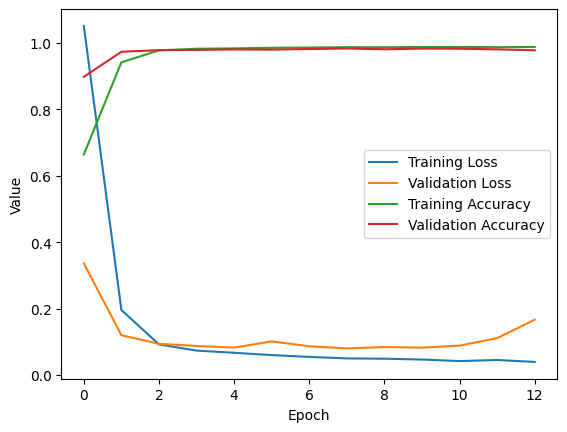

In [174]:
# Define early stopping callback to monitor validation loss and stop if it doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5)
# Create model
model_3 = classifier_model(X_train_sc,Y_train_enc)
model_3.summary()
# Train the model with 20 epochs and batch size of 32, using the early stopping callback
history = model_3.fit(X_train_sc, Y_train_enc, epochs=200, batch_size=256, validation_data=(X_cv_sc, Y_cv_enc), callbacks=[early_stop])

# Plot the training history for loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

In [175]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Define custom class labels
custom_labels = ['0', '1', '2', '4', '6', '7', '11', '13', '14', '17', '19', '20']

# Create a function to plot the confusion matrix with custom labels
def plot_confusion_matrix_1(y_true, y_pred, title):
    f, ax = plt.subplots(figsize=(15, 15))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', ax=ax,
                xticklabels=custom_labels, yticklabels=custom_labels)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_ylim(len(cm), 0)
    plt.tight_layout()
    plt.show()

    f, ax = plt.subplots(figsize=(15, 15))
    precision = confusion_matrix(y_true, y_pred, normalize='pred')
    sns.heatmap(precision, annot=True, cmap='Blues', ax=ax,
                xticklabels=custom_labels, yticklabels=custom_labels)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_ylim(len(precision), 0)
    plt.tight_layout()
    plt.show()

    f, ax = plt.subplots(figsize=(15, 15))
    recall = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(recall, annot=True, cmap='Blues', ax=ax,
                xticklabels=custom_labels, yticklabels=custom_labels)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_ylim(len(recall), 0)
    plt.tight_layout()
    plt.show()


    trace = np.diag(precision)

     # Sum of the trace (the sum of the diagonal elements of the confusion matrix) gives total true positives
    total_true_positives = np.sum(trace)

# Calculate the aggregate precision including class '0'
# Divide the total true positives by the number of classes
    aggregate_precision_including = total_true_positives / len(custom_labels)
    print(f"Aggregate Precision (including all classes): {aggregate_precision_including:.3f}")

# Calculate the aggregate precision excluding class '0'
# Subtract the true positives of class '0' from the total true positives and divide by the number of classes minus one
    aggregate_precision_excluding = (total_true_positives - trace[0]) / (len(custom_labels) - 1)
    print(f"Aggregate Precision (excluding class '0'): {aggregate_precision_excluding:.3f}")


In [176]:
y_pred = enc_1.inverse_transform(model_3.predict(X_test_sc, verbose=0))

In [177]:
y_true = enc_1.inverse_transform(Y_test_enc)

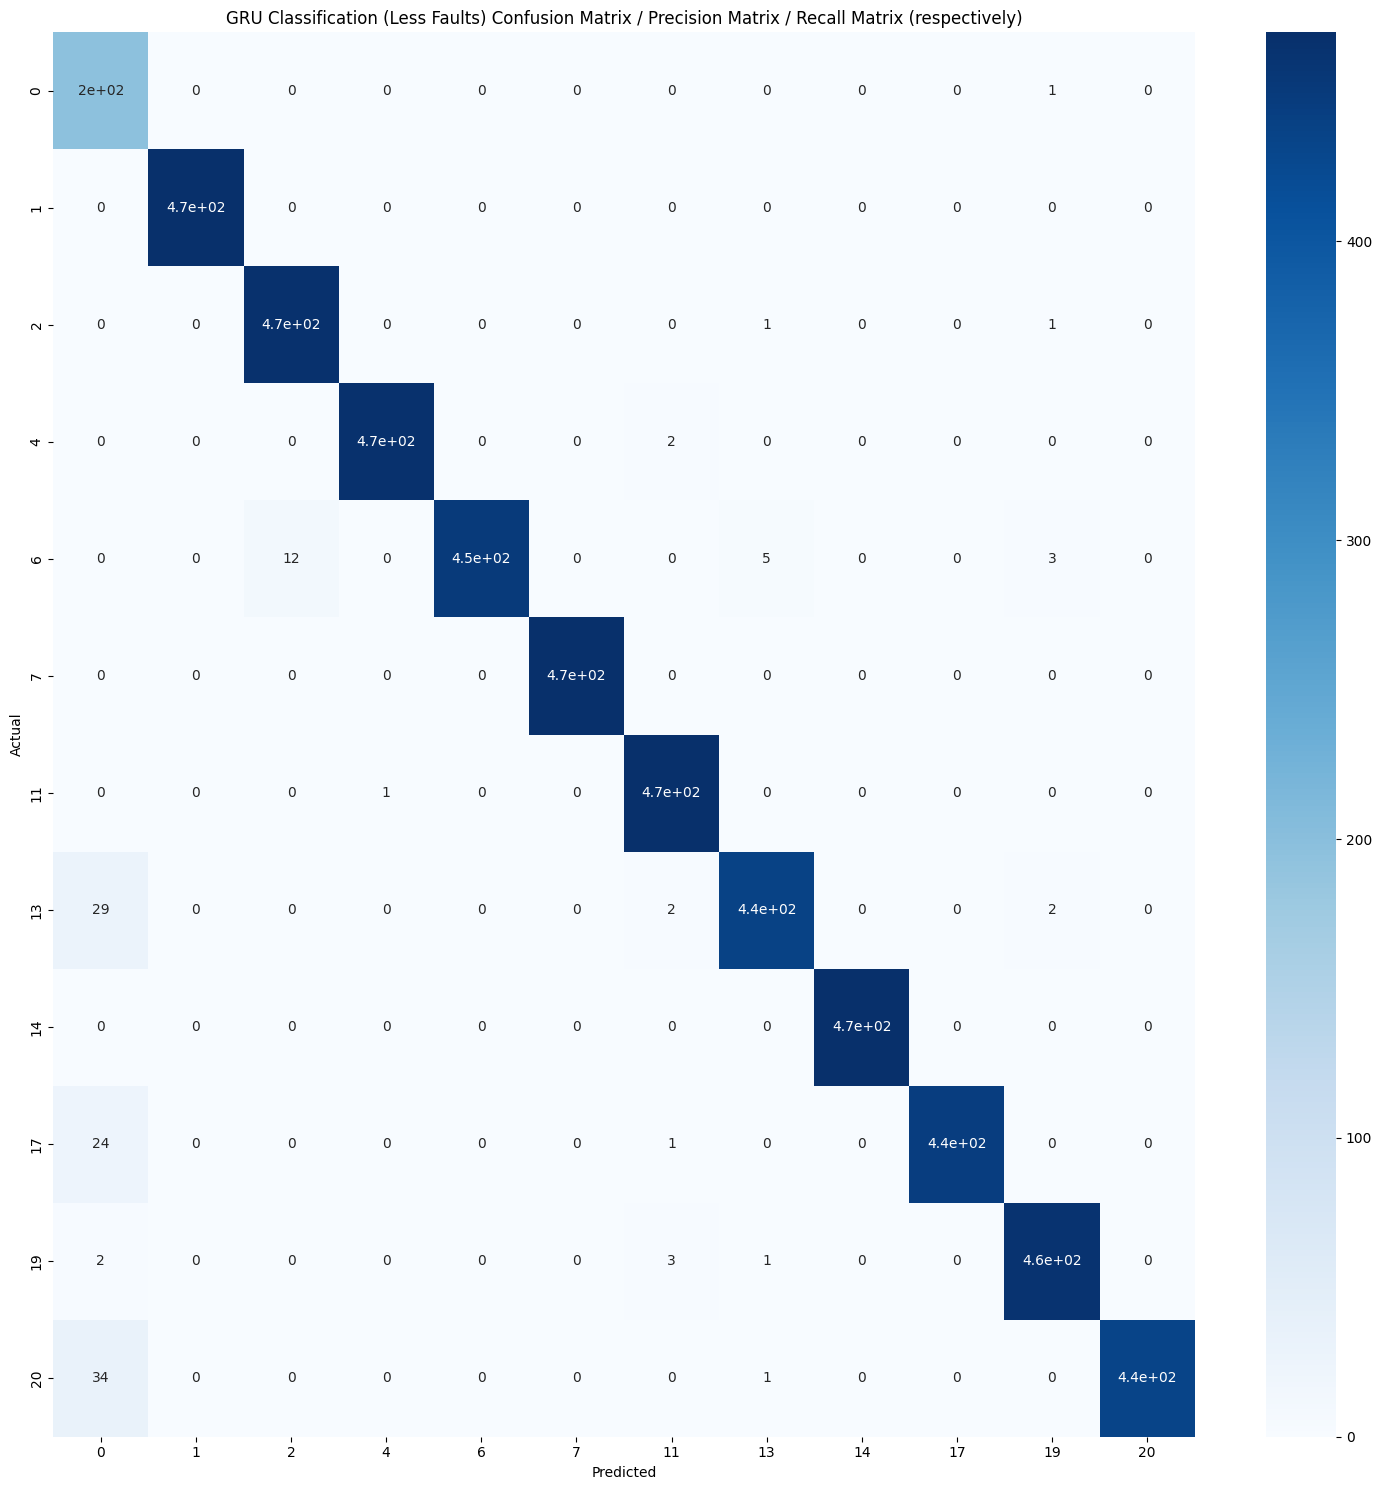

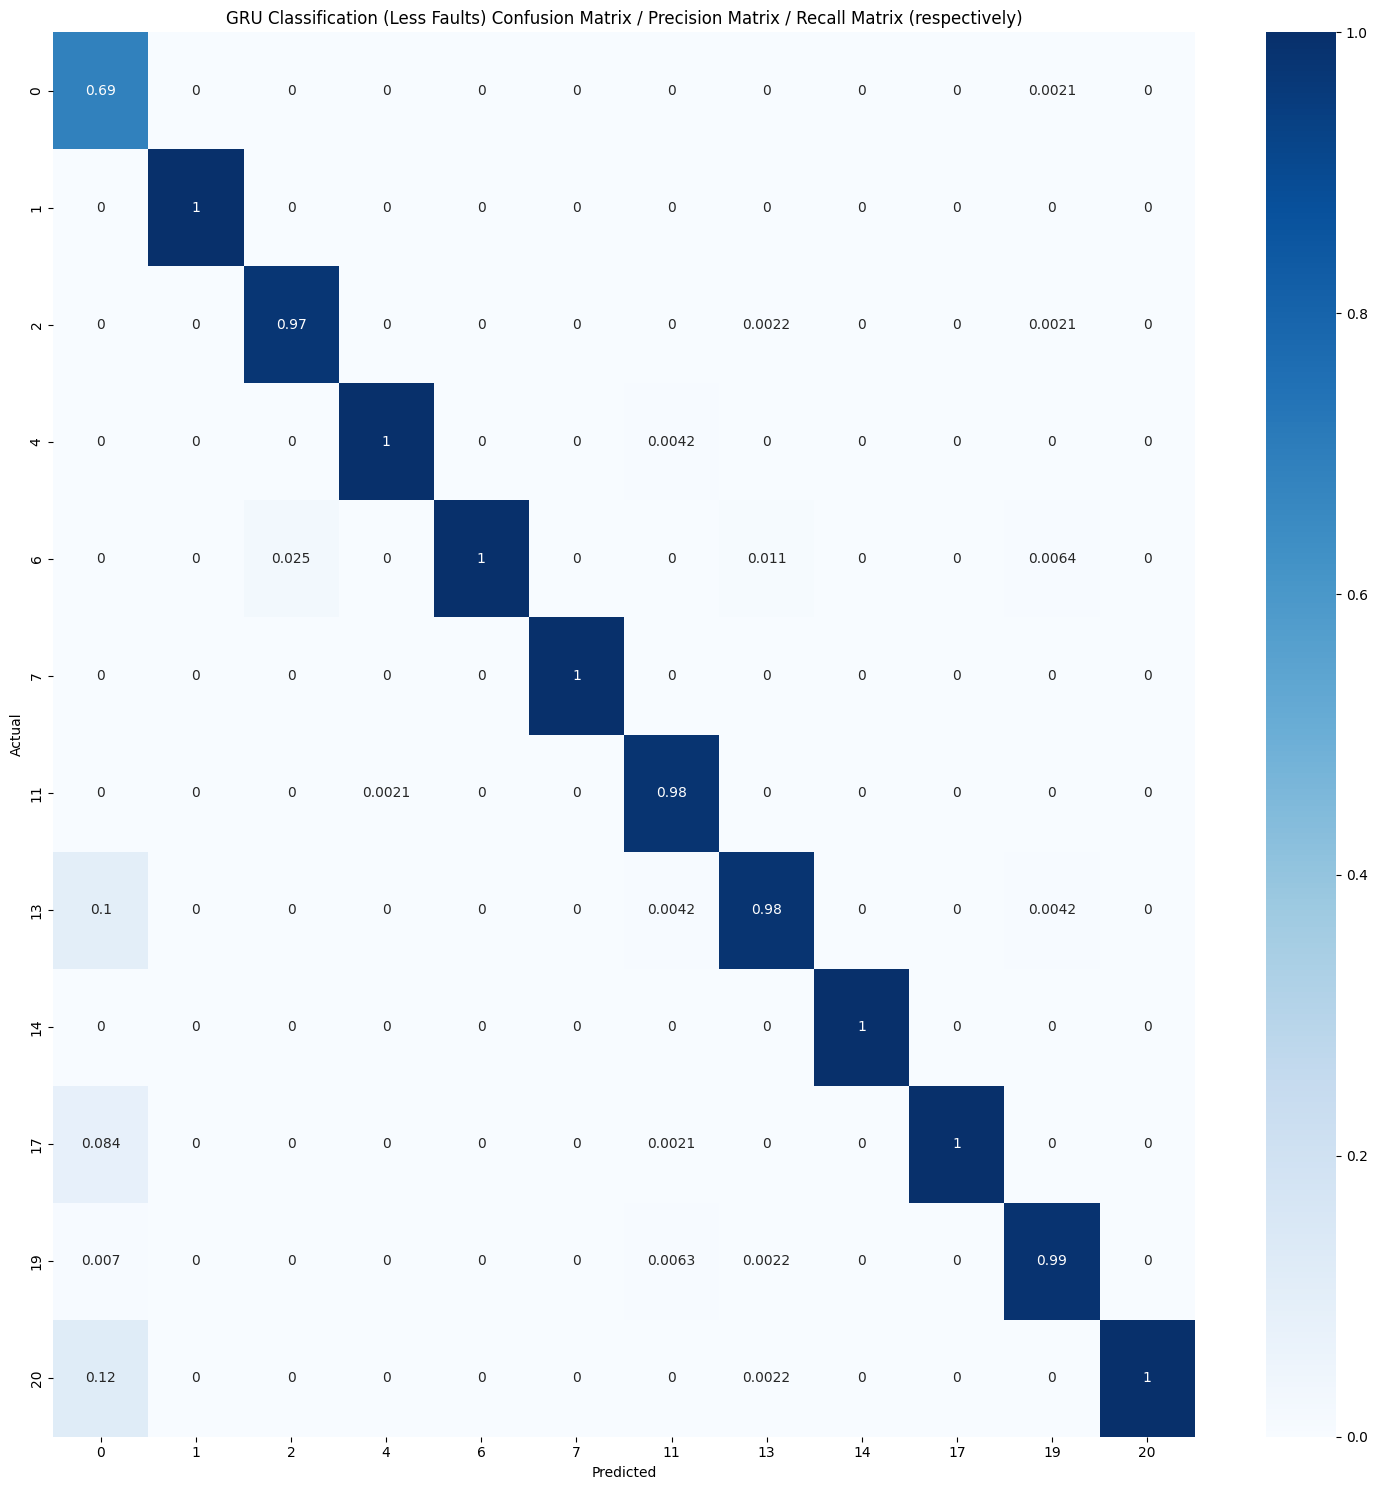

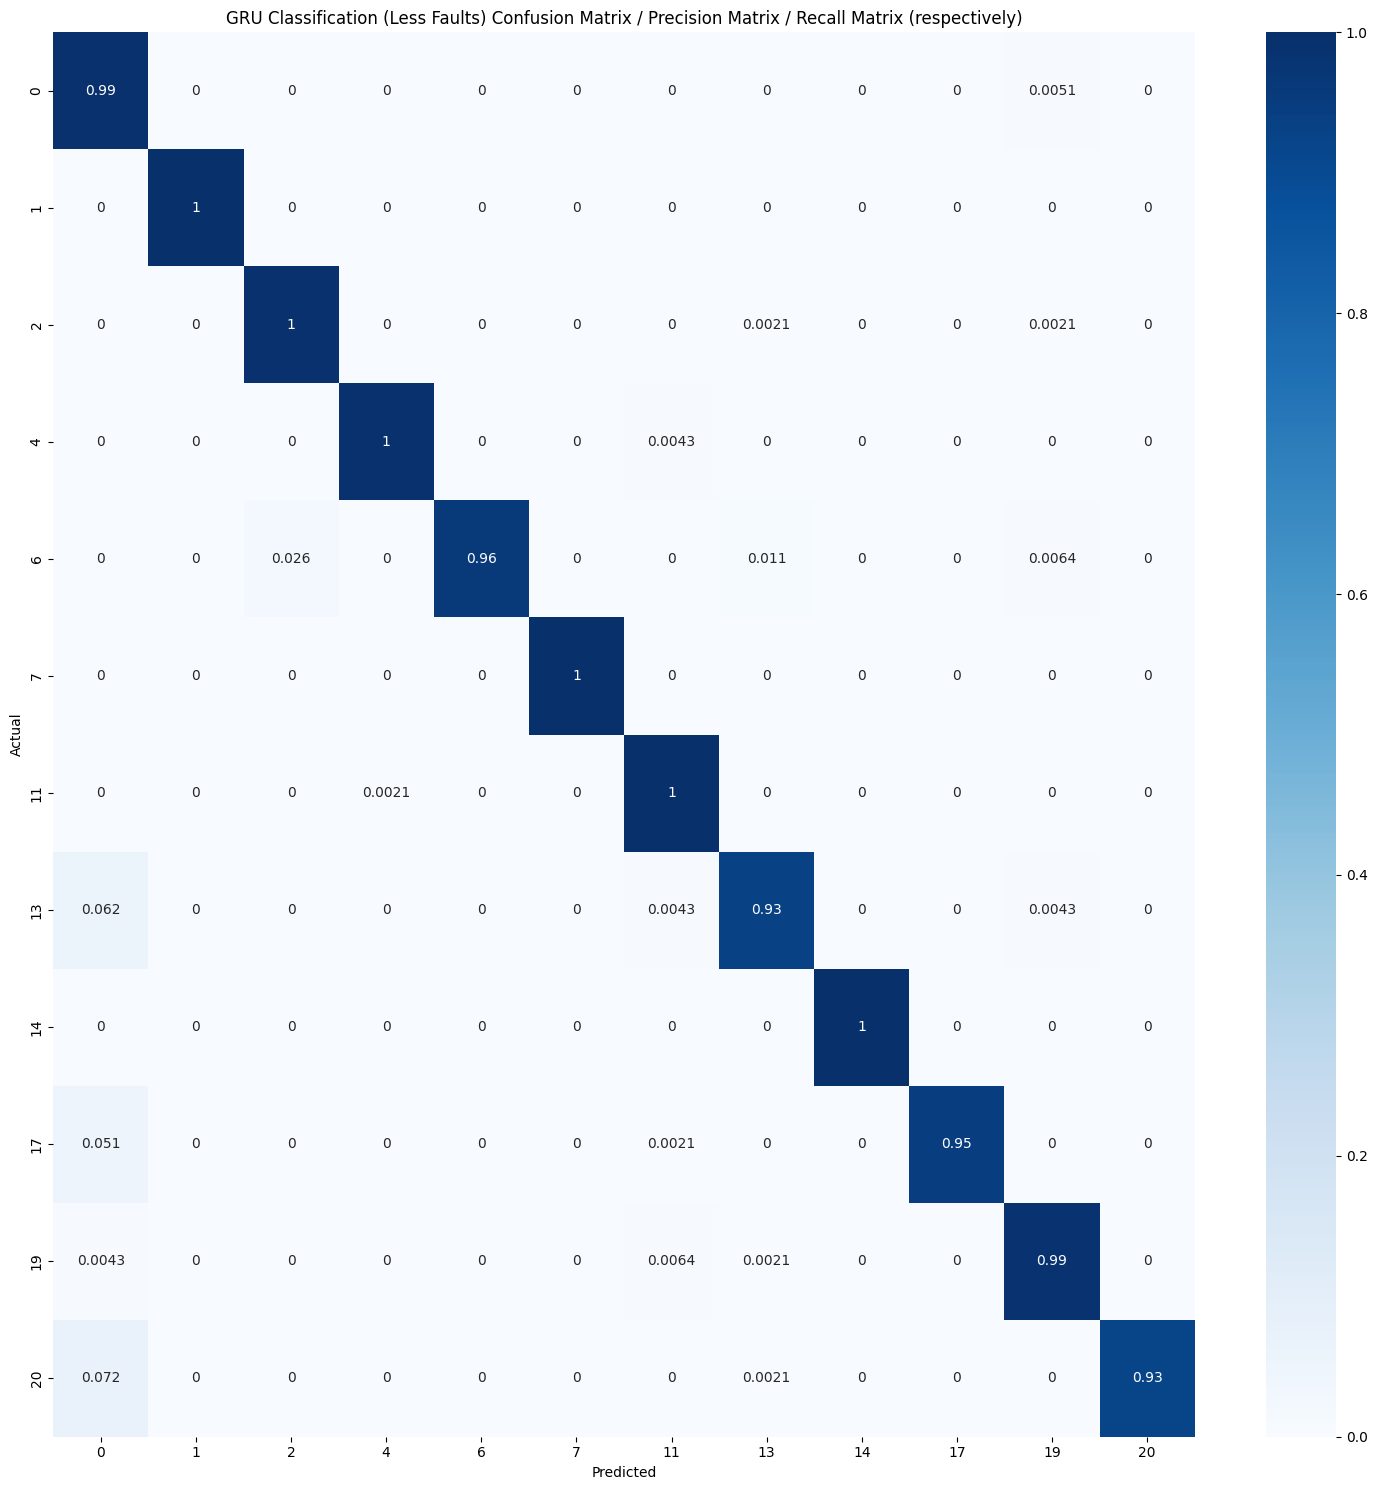

Aggregate Precision (including all classes): 0.968
Aggregate Precision (excluding class '0'): 0.993
GRU Classification (Less Faults) accuracy_score: 0.9767095211477548
GRU Classification (Less Faults) f1 score micro: 0.9767095211477548
GRU Classification (Less Faults) f1 score macro: 0.969956931723206
GRU Classification (Less Faults) f1 score weighted: 0.9779266254245056
GRU Classification (Less Faults) f1 score none: [0.81327801 1.         0.98526316 0.99680511 0.97826087 1.
 0.9904963  0.95519126 1.         0.9726776  0.98618491 0.96132597]


In [178]:
plot_confusion_matrix_1(y_true, y_pred, 'GRU Classification (Less Faults) Confusion Matrix / Precision Matrix / Recall Matrix (respectively)')
print("GRU Classification (Less Faults) accuracy_score:", accuracy_score(y_true, y_pred))
from sklearn.metrics import f1_score

# Option 1: Use 'micro' average
print("GRU Classification (Less Faults) f1 score micro:", f1_score(y_true, y_pred, average='micro'))

# Option 2: Use 'macro' average
print("GRU Classification (Less Faults) f1 score macro:", f1_score(y_true, y_pred, average='macro'))

# Option 3: Use 'weighted' average
print("GRU Classification (Less Faults) f1 score weighted:", f1_score(y_true, y_pred, average='weighted'))

# Option 4: Get F1 score for each class (No average)
print("GRU Classification (Less Faults) f1 score none:", f1_score(y_true, y_pred, average=None))



In [84]:





#############Autoencoder + ANN (Less Faults)#################





In [85]:
# Removing faults 3, 5, 8, 9, 10, 12, 15, 16, and 18.
tr_2 = train.drop(train[(train.faultNumber == 3) | (train.faultNumber == 9) | (train.faultNumber == 15) | (train.faultNumber == 5) | (train.faultNumber == 8) | (train.faultNumber == 10) | (train.faultNumber == 12) | (train.faultNumber == 16) | (train.faultNumber == 18)].index).reset_index()
ts_2 = test.drop(test[(test.faultNumber == 3) | (test.faultNumber == 9) | (test.faultNumber == 15) | (test.faultNumber == 5) | (test.faultNumber == 8) | (test.faultNumber == 10) | (test.faultNumber == 12) | (test.faultNumber == 16) | (test.faultNumber == 18)].index).reset_index()
cv_2 = cv.drop(cv[(cv.faultNumber == 3) | (cv.faultNumber == 9) | (cv.faultNumber == 15) | (cv.faultNumber == 5) | (cv.faultNumber == 8) | (cv.faultNumber == 10) | (cv.faultNumber == 12) | (cv.faultNumber == 16) | (cv.faultNumber == 18)].index).reset_index()

In [86]:
# Map fault numbers to a new continuous range
mapping = {0:0, 1:1, 2:2, 4:3, 6:4, 7:5, 11:6, 13:7, 14:8, 17:9, 19:10, 20:11}
tr_2['mappedFaultNumber'] = tr_2['faultNumber'].map(mapping)
ts_2['mappedFaultNumber'] = ts_2['faultNumber'].map(mapping)
cv_2['mappedFaultNumber'] = cv_2['faultNumber'].map(mapping)

In [87]:
 # Column names to drop
columns_to_drop = tr_2.columns[27:46]

# Drop the columns from the dataframes
tr_2.drop(columns_to_drop, axis=1, inplace=True)
ts_2.drop(columns_to_drop, axis=1, inplace=True)
cv_2.drop(columns_to_drop, axis=1, inplace=True)


In [88]:
X_train_2d_1 = tr_2.copy()
X_test_2d_1 = ts_2.copy()
X_cv_2d_1 = cv_2.copy()

In [89]:
var_train_1 = pd.DataFrame(X_train_2d_1.iloc[:,5:-1])
var_test_1 = pd.DataFrame(X_test_2d_1.iloc[:,5:-1])
var_cv_1 = pd.DataFrame(X_cv_2d_1.iloc[:,5:-1])

In [90]:
var_test_1.shape

(54800, 33)

In [91]:
y_train_2d_1 = X_train_2d_1['mappedFaultNumber'].values
y_test_2d_1 = X_test_2d_1['mappedFaultNumber'].values
y_cv_2d_1 = X_cv_2d_1['mappedFaultNumber'].values

In [93]:
y_train_2d_df_1 = pd.DataFrame(y_train_2d_1)
y_test_2d_df_1 = pd.DataFrame(y_test_2d_1)
y_cv_2d_df_1 = pd.DataFrame(y_cv_2d_1)
print(y_train_2d_df_1.shape)
print(y_test_2d_df_1.shape)
print(y_cv_2d_df_1.shape)

(152000, 1)
(54800, 1)
(62800, 1)


In [94]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training data
var_train_sc_1 = scaler.fit_transform(var_train_1)

# Transform the test and cv data
var_test_sc_1 = scaler.transform(var_test_1)
var_cv_sc_1 = scaler.transform(var_cv_1)

In [95]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the encoder
encoder_1 = OneHotEncoder(sparse=False)

# Fit the encoder on the training target data and transform the training target data
Y_train_2d_enc_1 = encoder_1.fit_transform(y_train_2d_1.reshape(-1, 1))

# Transform the test and cv target data
Y_test_2d_enc_1 = encoder_1.transform(y_test_2d_1.reshape(-1, 1))
Y_cv_2d_enc_1 = encoder_1.transform(y_cv_2d_1.reshape(-1, 1))


In [96]:
Y_train_2d_enc_1.shape

(152000, 12)

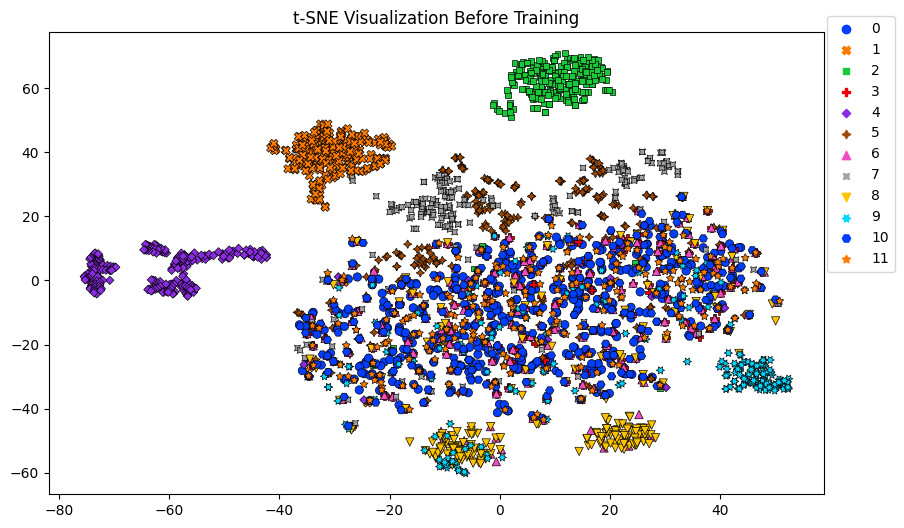

In [97]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder # Assuming you used this for encoding


# Apply t-SNE
x_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(var_train_sc_1[::50, :])

# Inverse transform your encoded labels
y_label = encoder_1.inverse_transform(Y_train_2d_enc_1[::50, :]).reshape(-1)

# Create a scatter plot of the embedded data, colored by the true labels
f, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=x_embedded[:, 0], y=x_embedded[:, 1], hue=y_label, style=y_label, palette="bright", edgecolor='black')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('t-SNE Visualization Before Training')
plt.show()


In [98]:
from keras.layers import Input, Dense
from keras.models import Model

def classifier_model_1(X_train, y_train):
    # Define the input layer
    input_layer = Input(shape=(X_train.shape[1],))

    # Define the encoder part (to create a latent space representation)
    encoder = Dense(64, activation='relu')(input_layer)
    latent_space = Dense(16, activation='relu')(encoder)  # This is the latent space representation

    # Define the classifier part using the latent space representation
    classifier = Dense(100, activation='selu')(latent_space)
    classifier = Dense(50, activation='selu')(classifier)
    outputs = Dense(y_train.shape[1], activation='softmax')(classifier)  # Output layer for classification

    # Define the classifier model
    model = Model(inputs=input_layer, outputs=outputs)

    # Compile the classifier
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 33)]              0         
                                                                 
 dense_6 (Dense)             (None, 64)                2176      
                                                                 
 dense_7 (Dense)             (None, 16)                1040      
                                                                 
 dense_8 (Dense)             (None, 100)               1700      
                                                                 
 dense_9 (Dense)             (None, 50)                5050      
                                                                 
 dense_10 (Dense)            (None, 12)                612       
                                                                 
Total params: 10578 (41.32 KB)
Trainable params: 10578 (41.

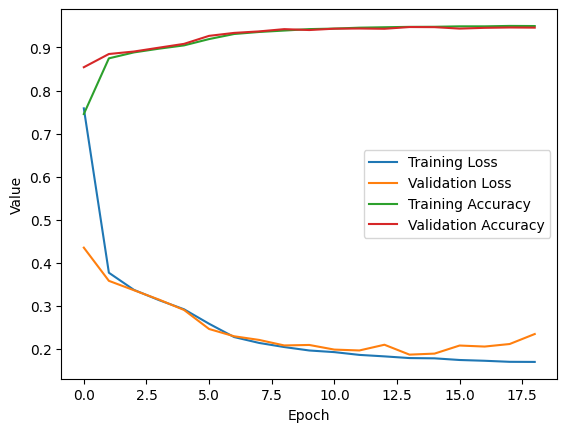

In [99]:
# Define early stopping callback to monitor validation loss and stop if it doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5)
# Create model
model_1 = classifier_model_1(var_train_sc_1,Y_train_2d_enc_1)
model_1.summary()
# Train the model with 20 epochs and batch size of 32, using the early stopping callback
history = model_1.fit(var_train_sc_1,Y_train_2d_enc_1, epochs=200, batch_size=256, validation_data=(var_cv_sc_1,Y_cv_2d_enc_1), callbacks=[early_stop])

# Plot the training history for loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Define custom class labels
custom_labels = ['0', '1', '2', '4', '6', '7', '11', '13', '14', '17', '19', '20']

# Create a function to plot the confusion matrix with custom labels
def plot_confusion_matrix_1(y_true, y_pred, title):
    f, ax = plt.subplots(figsize=(15, 15))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', ax=ax,
                xticklabels=custom_labels, yticklabels=custom_labels)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_ylim(len(cm), 0)
    plt.tight_layout()
    plt.show()

    f, ax = plt.subplots(figsize=(15, 15))
    precision = confusion_matrix(y_true, y_pred, normalize='pred')
    sns.heatmap(precision, annot=True, cmap='Blues', ax=ax,
                xticklabels=custom_labels, yticklabels=custom_labels)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_ylim(len(precision), 0)
    plt.tight_layout()
    plt.show()

    f, ax = plt.subplots(figsize=(15, 15))
    recall = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(recall, annot=True, cmap='Blues', ax=ax,
                xticklabels=custom_labels, yticklabels=custom_labels)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_ylim(len(recall), 0)
    plt.tight_layout()
    plt.show()


    trace = np.diag(precision)

     # Sum of the trace (the sum of the diagonal elements of the confusion matrix) gives total true positives
    total_true_positives = np.sum(trace)

# Calculate the aggregate precision including class '0'
# Divide the total true positives by the number of classes
    aggregate_precision_including = total_true_positives / len(custom_labels)
    print(f"Aggregate Precision (including all classes): {aggregate_precision_including:.3f}")

# Calculate the aggregate precision excluding class '0'
# Subtract the true positives of class '0' from the total true positives and divide by the number of classes minus one
    aggregate_precision_excluding = (total_true_positives - trace[0]) / (len(custom_labels) - 1)
    print(f"Aggregate Precision (excluding class '0'): {aggregate_precision_excluding:.3f}")


In [101]:
y_pred = encoder_1.inverse_transform(model_1.predict(var_test_sc_1, verbose=0))

In [102]:
y_true = encoder_1.inverse_transform(Y_test_2d_enc_1)

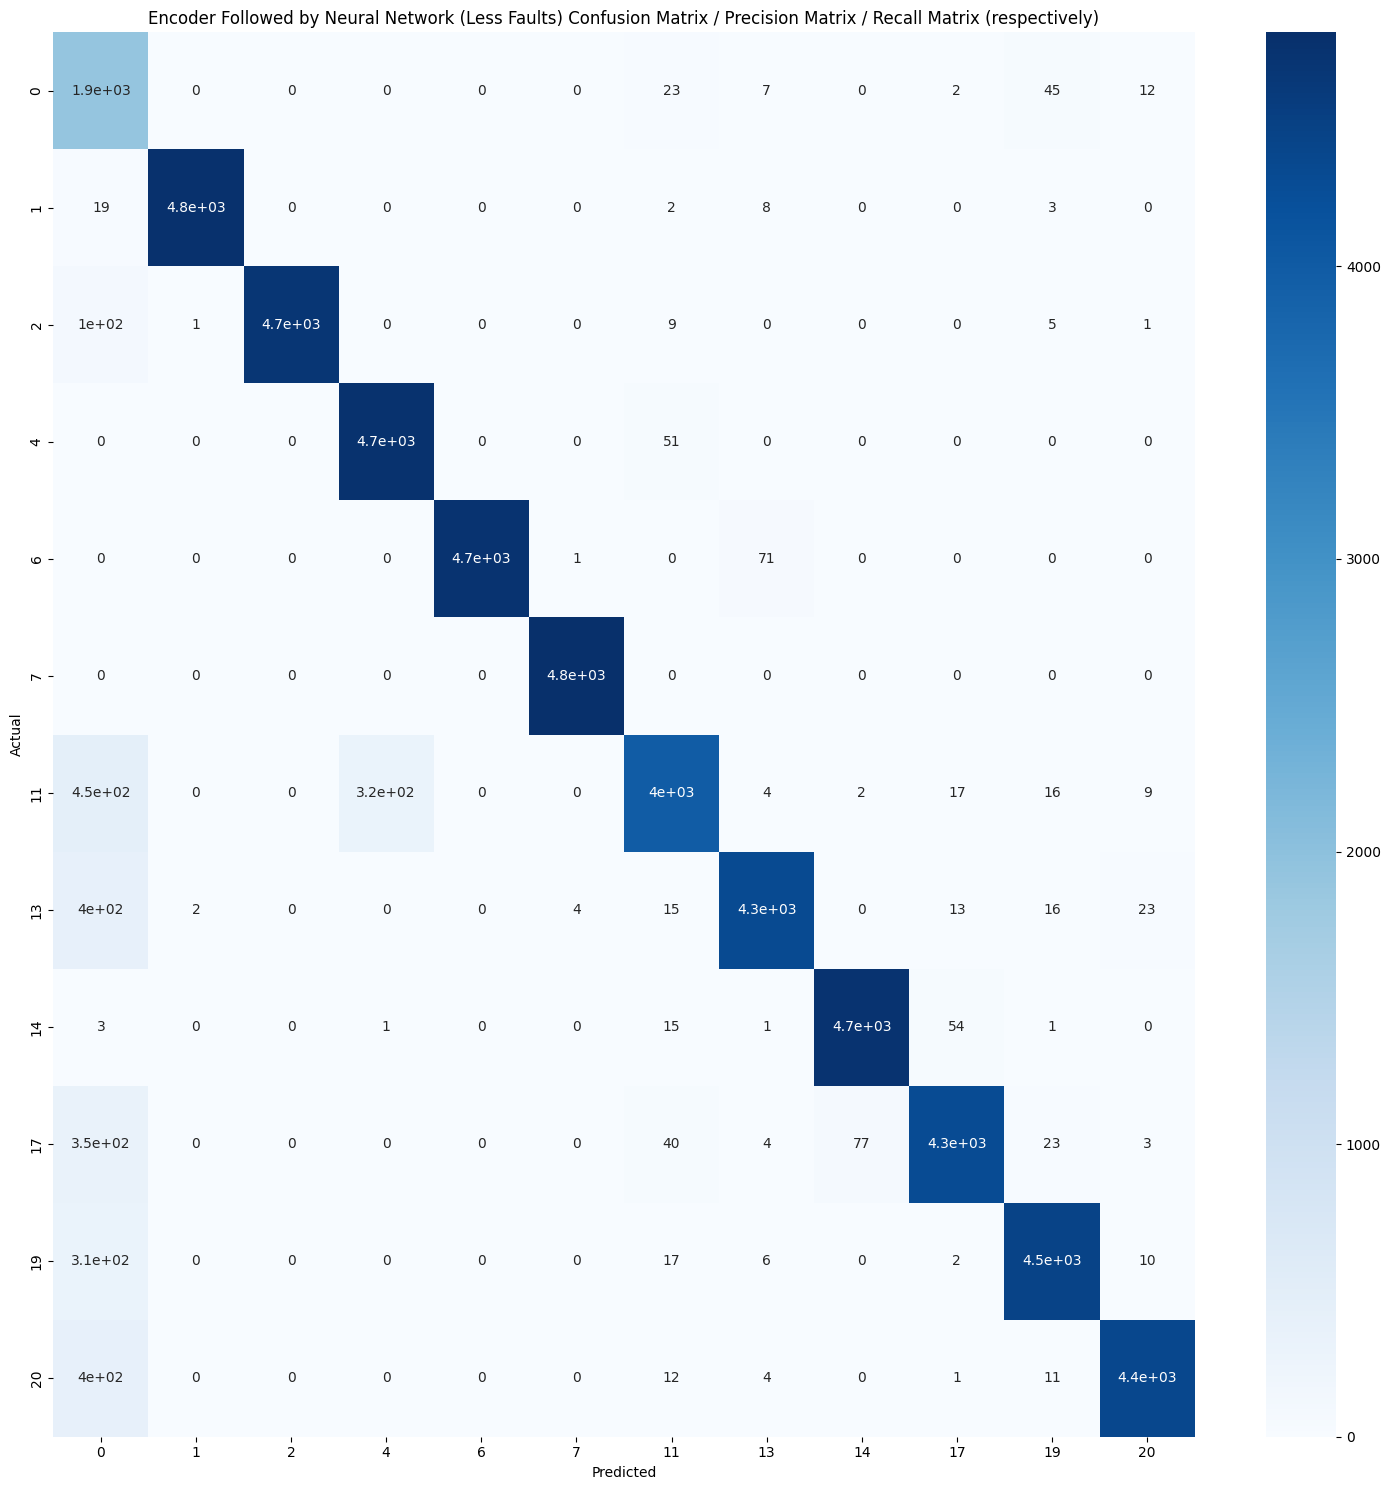

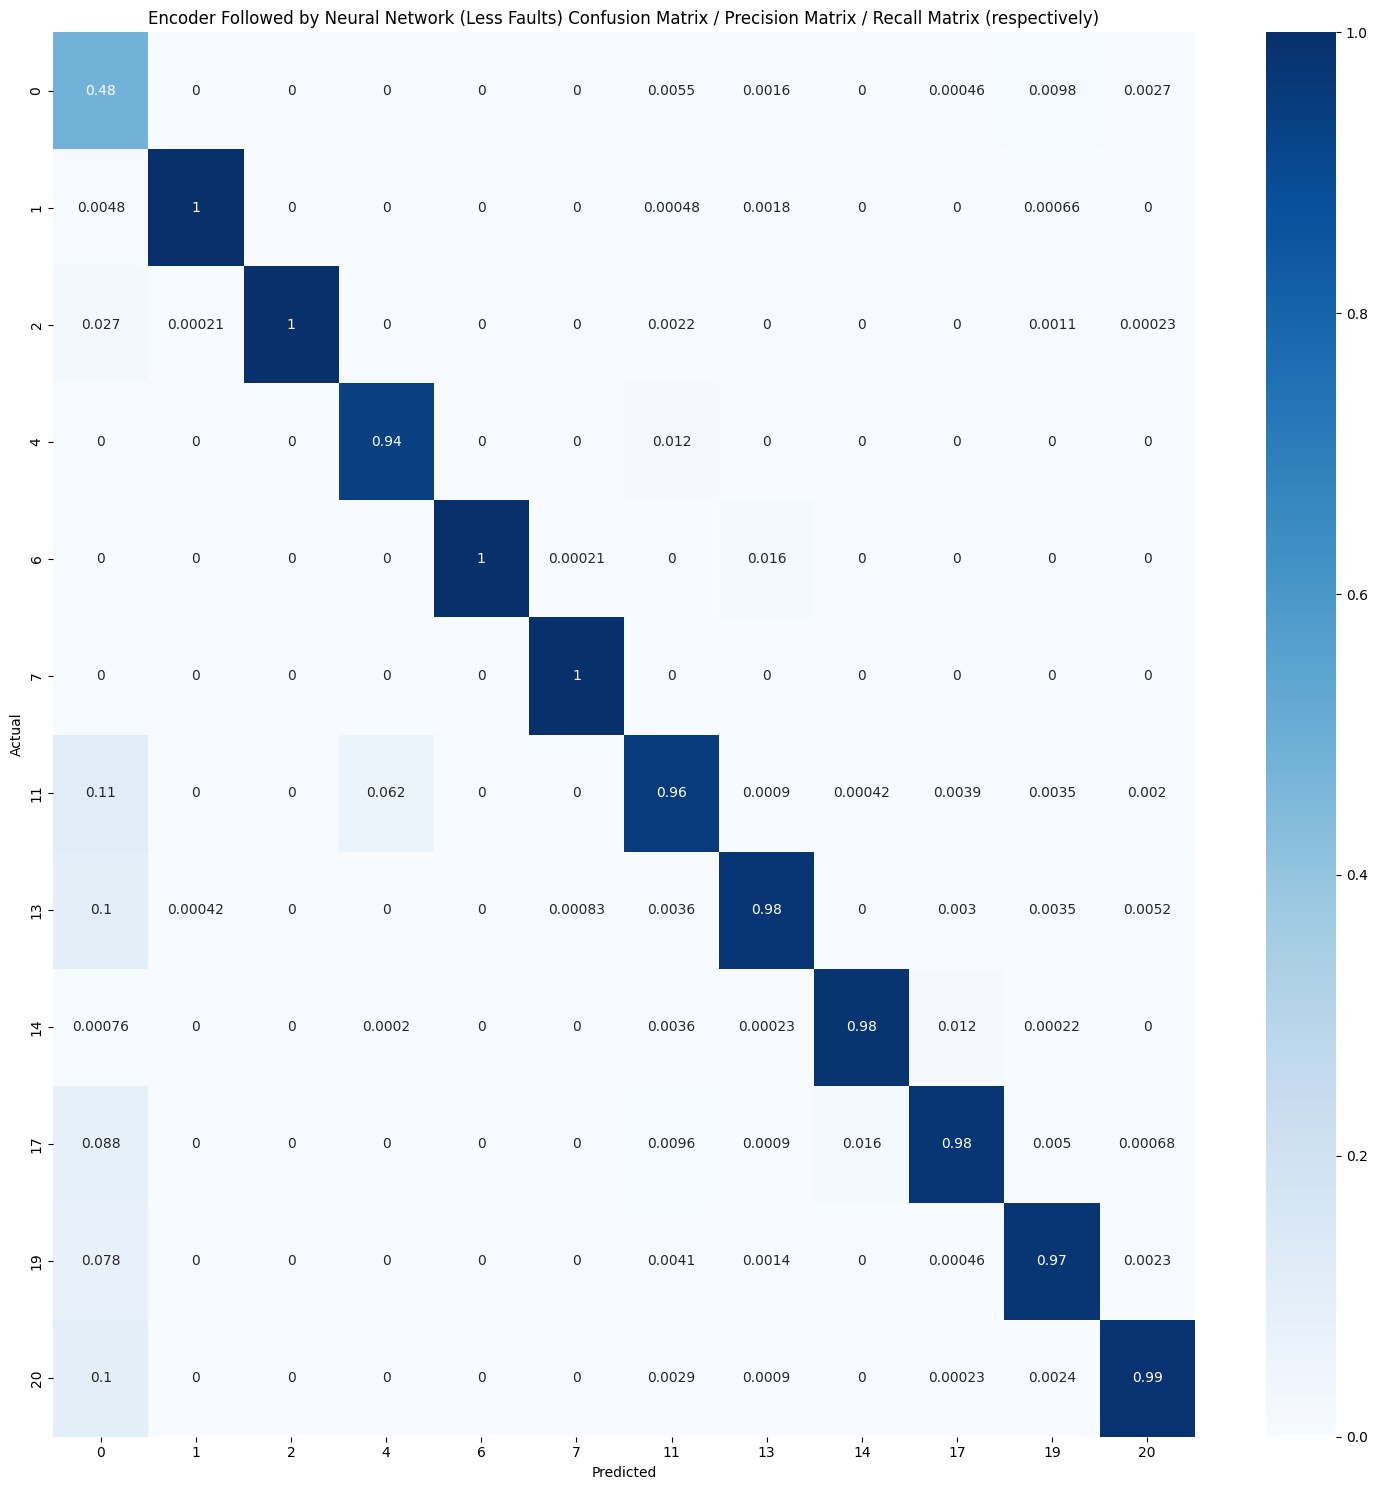

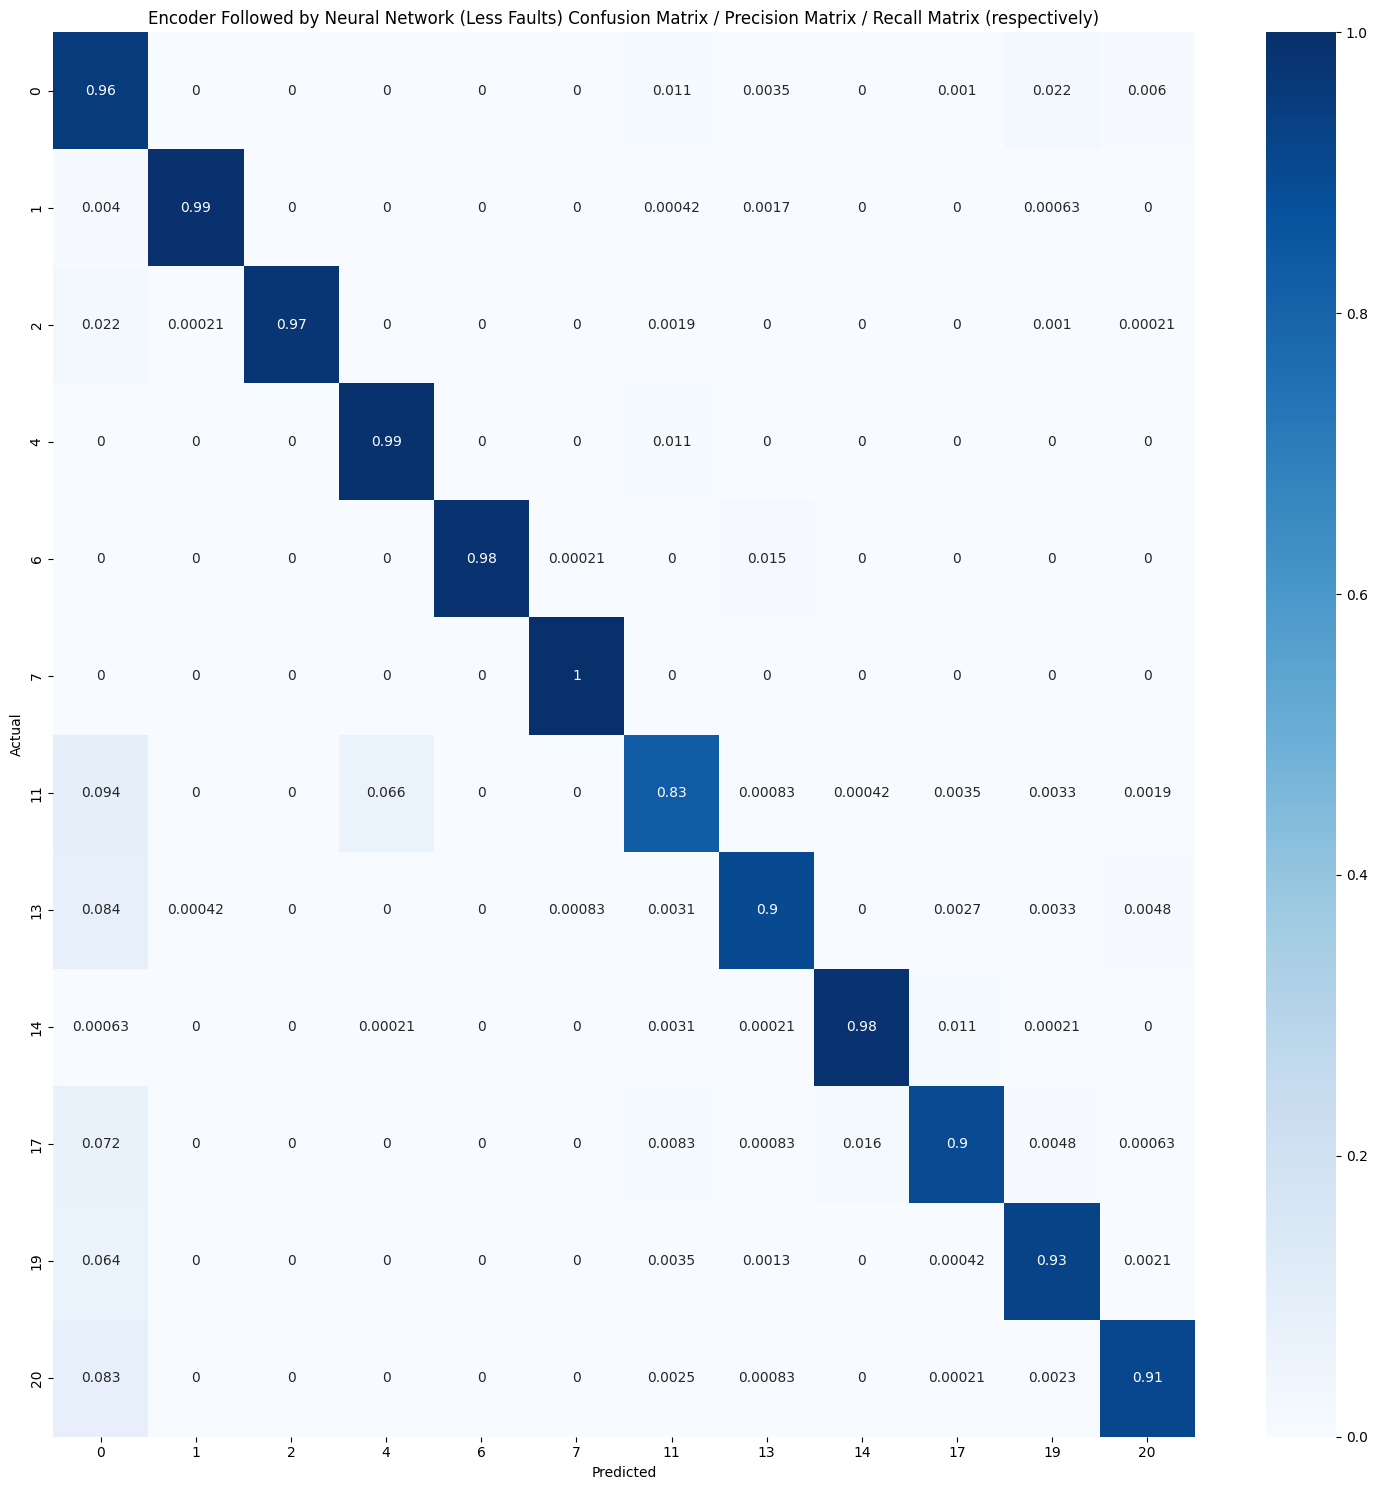

Aggregate Precision (including all classes): 0.940
Aggregate Precision (excluding class '0'): 0.981
Encoder followed by Neural Network (Less Faults) 0.9452919708029197
Encoder followed by Neural Network (Less Faults) f1 score micro: 0.9452919708029197
Encoder followed by Neural Network (Less Faults) f1 score macro: 0.9353837917114798
Encoder followed by Neural Network (Less Faults) f1 score weighted: 0.9503561709358963
Encoder followed by Neural Network (Less Faults) f1 score none: [0.64235294 0.99634312 0.98723494 0.96279777 0.99244332 0.99947944
 0.88849242 0.93693108 0.98396501 0.93659598 0.95062387 0.94734561]


In [103]:
plot_confusion_matrix_1(y_true, y_pred, 'Encoder Followed by Neural Network (Less Faults) Confusion Matrix / Precision Matrix / Recall Matrix (respectively)')
print("Encoder followed by Neural Network (Less Faults)", accuracy_score(y_true, y_pred))

from sklearn.metrics import f1_score

# Option 1: Use 'micro' average
print("Encoder followed by Neural Network (Less Faults) f1 score micro:", f1_score(y_true, y_pred, average='micro'))

# Option 2: Use 'macro' average
print("Encoder followed by Neural Network (Less Faults) f1 score macro:", f1_score(y_true, y_pred, average='macro'))

# Option 3: Use 'weighted' average
print("Encoder followed by Neural Network (Less Faults) f1 score weighted:", f1_score(y_true, y_pred, average='weighted'))

# Option 4: Get F1 score for each class (No average)
print("Encoder followed by Neural Network (Less Faults) f1 score none:", f1_score(y_true, y_pred, average=None))


In [104]:




###############Autoencoder + ANN (More Faults)##################





In [105]:
# Removing faults 3, 9, and 15
tr_3 = train.drop(train[(train.faultNumber == 3) | (train.faultNumber == 9) | (train.faultNumber == 15)].index).reset_index()
ts_3 = test.drop(test[(test.faultNumber == 3) | (test.faultNumber == 9) | (test.faultNumber == 15)].index).reset_index()
cv_3 = cv.drop(cv[(cv.faultNumber == 3) | (cv.faultNumber == 9) | (cv.faultNumber == 15)].index).reset_index()

In [106]:
# Map fault numbers to a new continuous range
mapping = {0:0, 1:1, 2:2, 4:3, 5:4, 6:5, 7:6, 8:7, 10:8, 11:9, 12:10, 13:11, 14:12, 16:13, 17:14, 18:15, 19:16, 20:17}
tr_3['mappedFaultNumber'] = tr_3['faultNumber'].map(mapping)
ts_3['mappedFaultNumber'] = ts_3['faultNumber'].map(mapping)
cv_3['mappedFaultNumber'] = cv_3['faultNumber'].map(mapping)

In [107]:
 # Column names to drop
columns_to_drop = tr_3.columns[27:46]

# Drop the columns from the dataframes
tr_3.drop(columns_to_drop, axis=1, inplace=True)
ts_3.drop(columns_to_drop, axis=1, inplace=True)
cv_3.drop(columns_to_drop, axis=1, inplace=True)


In [108]:
X_train_2d = tr_3.copy()
X_test_2d = ts_3.copy()
X_cv_2d = cv_3.copy()

In [109]:
var_train = pd.DataFrame(X_train_2d.iloc[:,5:-1])
var_test = pd.DataFrame(X_test_2d.iloc[:,5:-1])
var_cv = pd.DataFrame(X_cv_2d.iloc[:,5:-1])

In [110]:
[print(var_test.shape)]

(83600, 33)


[None]

In [111]:
y_train_2d = X_train_2d['mappedFaultNumber'].values
y_test_2d = X_test_2d['mappedFaultNumber'].values
y_cv_2d = X_cv_2d['mappedFaultNumber'].values

In [112]:
y_train_2d_df = pd.DataFrame(y_train_2d)
y_test_2d_df = pd.DataFrame(y_test_2d)
y_cv_2d_df = pd.DataFrame(y_cv_2d)
print(y_train_2d_df.shape)
print(y_test_2d_df.shape)
print(y_cv_2d_df.shape)

(224000, 1)
(83600, 1)
(91600, 1)


In [113]:
print(y_test_2d_df)

        0
0       0
1       0
2       0
3       0
4       0
...    ..
83595  17
83596  17
83597  17
83598  17
83599  17

[83600 rows x 1 columns]


In [114]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training data
var_train_sc = scaler.fit_transform(var_train)

# Transform the test and cv data
var_test_sc = scaler.transform(var_test)
var_cv_sc = scaler.transform(var_cv)

In [115]:
print(var_test_sc.shape)

(83600, 33)


In [116]:
shape_of_array = var_test_sc.shape

print("Shape of the array:", shape_of_array)

Shape of the array: (83600, 33)


In [117]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the encoder
encoder = OneHotEncoder(sparse=False)

# Fit the encoder on the training target data and transform the training target data
Y_train_2d_enc= encoder.fit_transform(y_train_2d.reshape(-1, 1))

# Transform the test and cv target data
Y_test_2d_enc = encoder.transform(y_test_2d.reshape(-1, 1))
Y_cv_2d_enc = encoder.transform(y_cv_2d.reshape(-1, 1))


In [118]:
print(Y_test_2d_enc.shape)

(83600, 18)


In [119]:
from keras.layers import Input, Dense
from keras.models import Model

def classifier_model_1(X_train, y_train):
    # Define the input layer
    input_layer = Input(shape=(X_train.shape[1],))

    # Define the encoder part (to create a latent space representation)
    encoder = Dense(64, activation='relu')(input_layer)
    latent_space = Dense(16, activation='relu')(encoder)  # This is the latent space representation

    # Define the classifier part using the latent space representation
    classifier = Dense(100, activation='selu')(latent_space)
    classifier = Dense(50, activation='selu')(classifier)
    outputs = Dense(y_train.shape[1], activation='softmax')(classifier)  # Output layer for classification

    # Define the classifier model
    model = Model(inputs=input_layer, outputs=outputs)

    # Compile the classifier
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 33)]              0         
                                                                 
 dense_11 (Dense)            (None, 64)                2176      
                                                                 
 dense_12 (Dense)            (None, 16)                1040      
                                                                 
 dense_13 (Dense)            (None, 100)               1700      
                                                                 
 dense_14 (Dense)            (None, 50)                5050      
                                                                 
 dense_15 (Dense)            (None, 18)                918       
                                                                 
Total params: 10884 (42.52 KB)
Trainable params: 10884 (42.

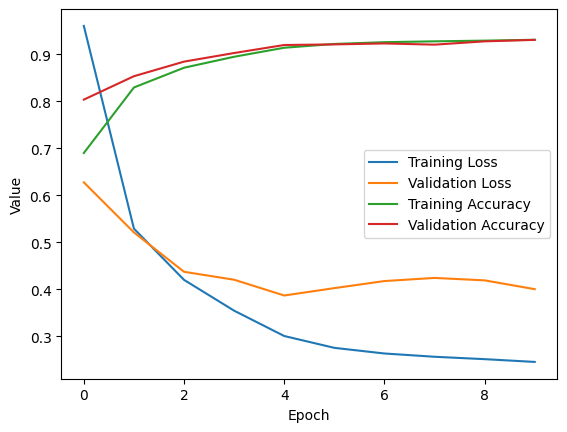

In [120]:
# Define early stopping callback to monitor validation loss and stop if it doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5)
# Create model
model_2 = classifier_model_1(var_train_sc,Y_train_2d_enc)
model_2.summary()
# Train the model with 20 epochs and batch size of 32, using the early stopping callback
history = model_2.fit(var_train_sc,Y_train_2d_enc, epochs=200, batch_size=256, validation_data=(var_cv_sc,Y_cv_2d_enc), callbacks=[early_stop])

# Plot the training history for loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Define custom class labels
custom_labels = ['0', '1', '2', '4', '5', '6', '7', '8', '10,','11', '12', '13', '14', '16', '17', '18', '19','20']

# Create a function to plot the confusion matrix with custom labels
def plot_confusion_matrix_1(y_true, y_pred, title):
    f, ax = plt.subplots(figsize=(15, 15))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', ax=ax,
                xticklabels=custom_labels, yticklabels=custom_labels)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_ylim(len(cm), 0)
    plt.tight_layout()
    plt.show()

    f, ax = plt.subplots(figsize=(15, 15))
    precision = confusion_matrix(y_true, y_pred, normalize='pred')
    sns.heatmap(precision, annot=True, cmap='Blues', ax=ax,
                xticklabels=custom_labels, yticklabels=custom_labels)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_ylim(len(precision), 0)
    plt.tight_layout()
    plt.show()

    f, ax = plt.subplots(figsize=(15, 15))
    recall = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(recall, annot=True, cmap='Blues', ax=ax,
                xticklabels=custom_labels, yticklabels=custom_labels)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_ylim(len(recall), 0)
    plt.tight_layout()
    plt.show()


    trace = np.diag(precision)

     # Sum of the trace (the sum of the diagonal elements of the confusion matrix) gives total true positives
    total_true_positives = np.sum(trace)

# Calculate the aggregate precision including class '0'
# Divide the total true positives by the number of classes
    aggregate_precision_including = total_true_positives / len(custom_labels)
    print(f"Aggregate Precision (including all classes): {aggregate_precision_including:.3f}")

# Calculate the aggregate precision excluding class '0'
# Subtract the true positives of class '0' from the total true positives and divide by the number of classes minus one
    aggregate_precision_excluding = (total_true_positives - trace[0]) / (len(custom_labels) - 1)
    print(f"Aggregate Precision (excluding class '0'): {aggregate_precision_excluding:.3f}")


In [122]:
y_pred_1 = encoder.inverse_transform(model_2.predict(var_test_sc, verbose=0))

In [123]:
y_true = encoder.inverse_transform(Y_test_2d_enc)

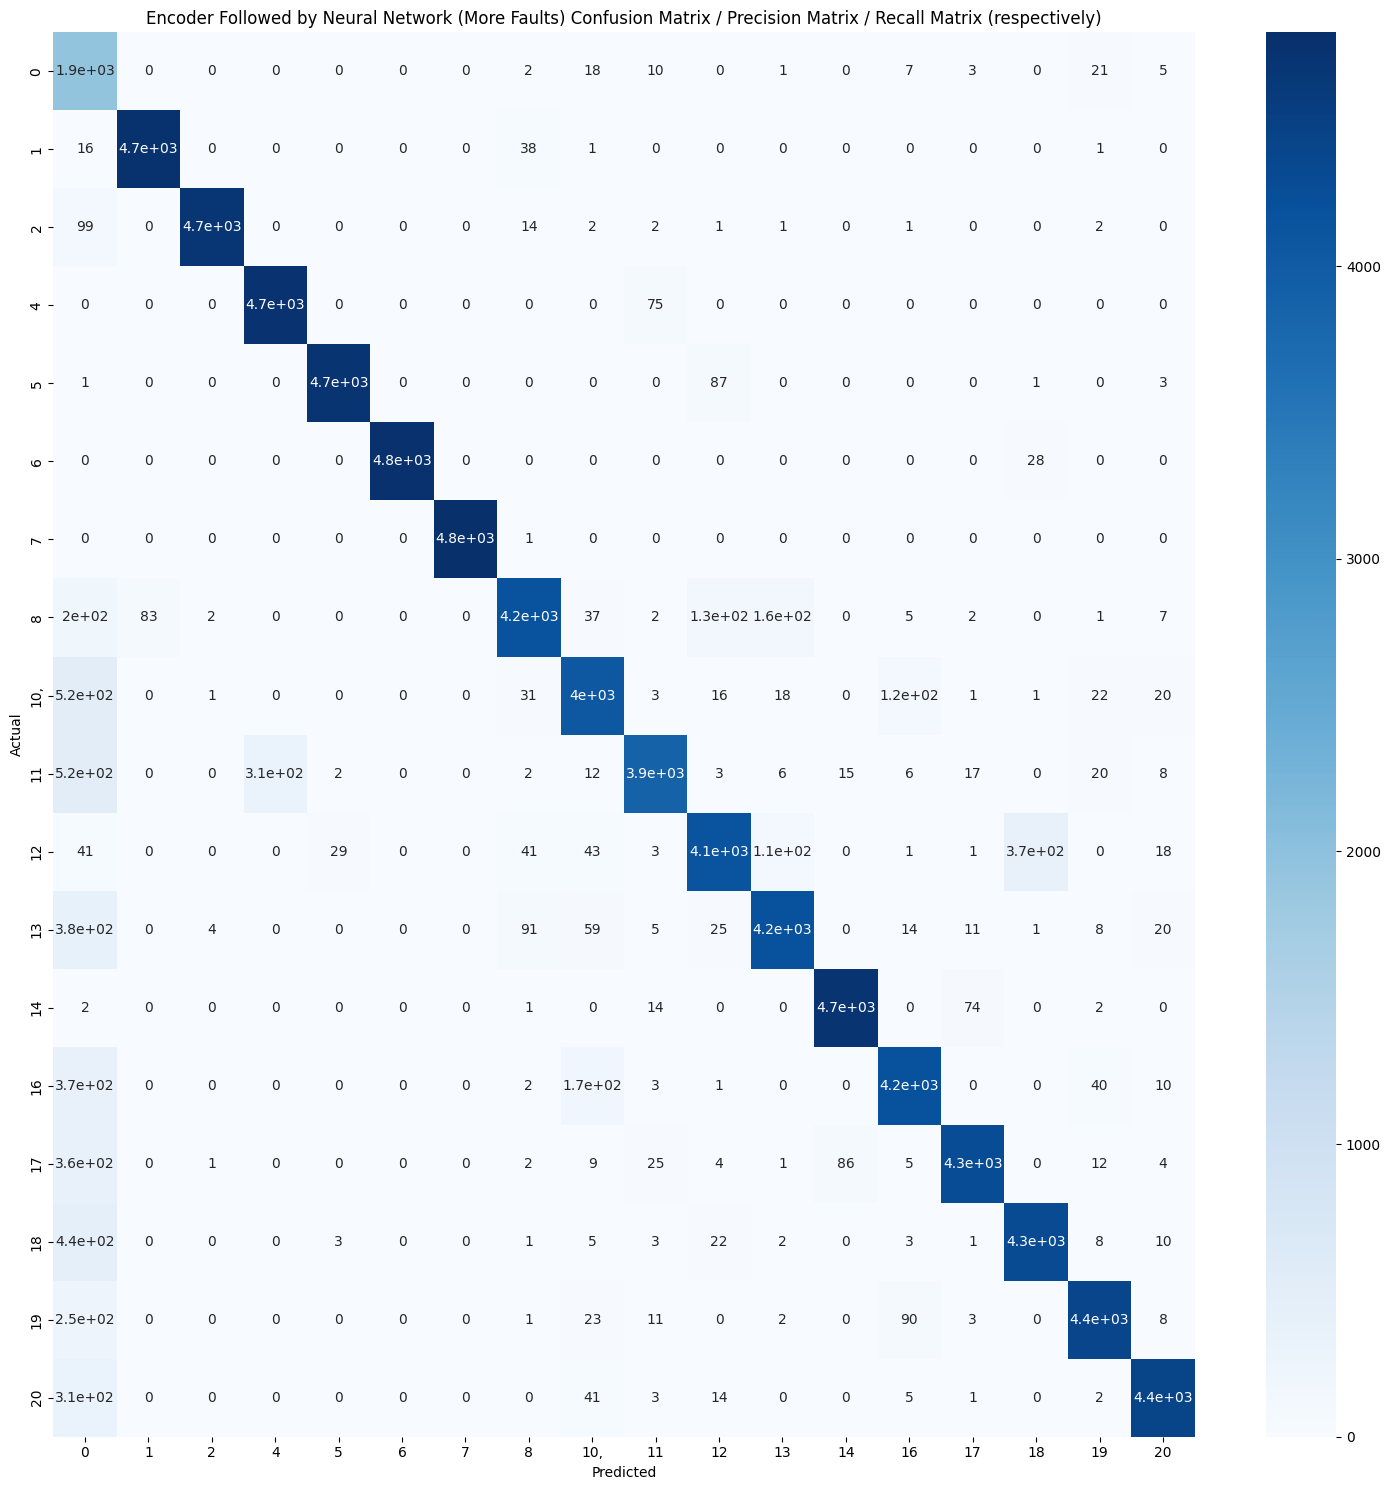

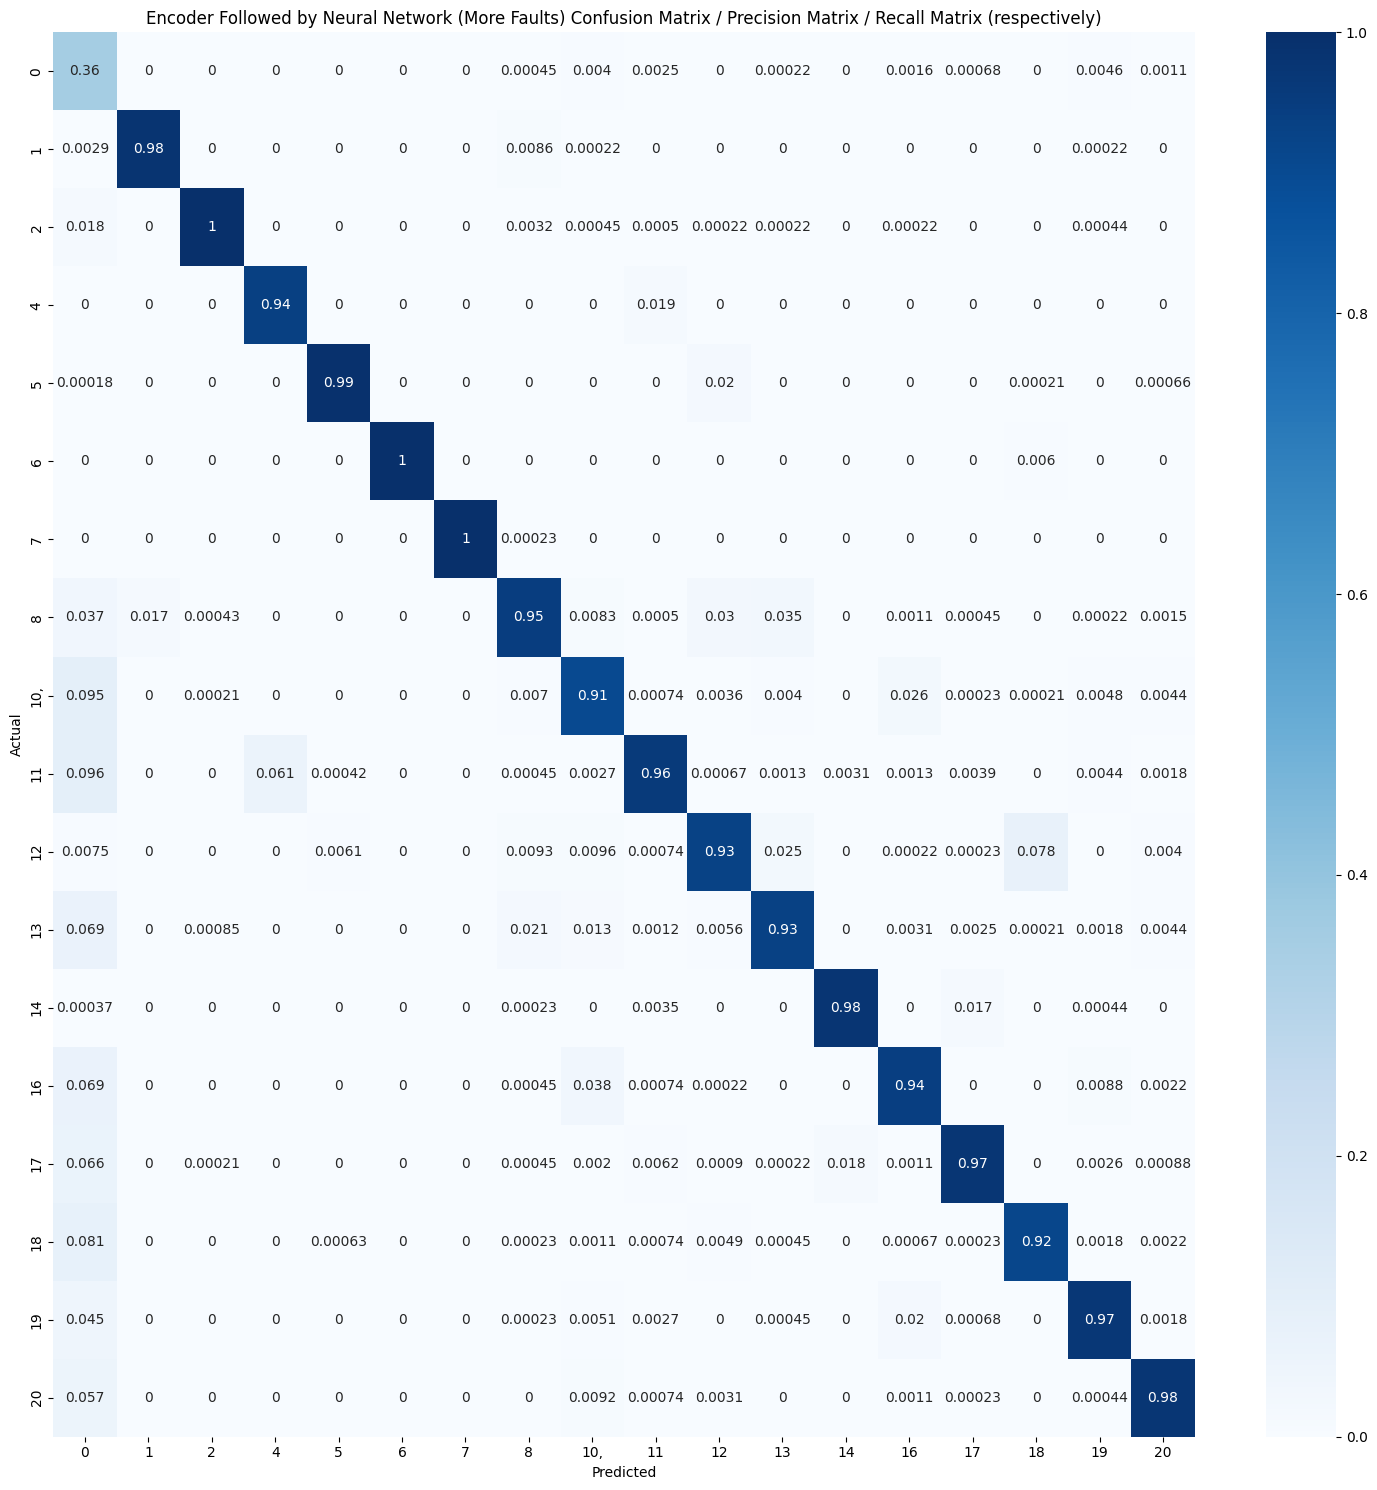

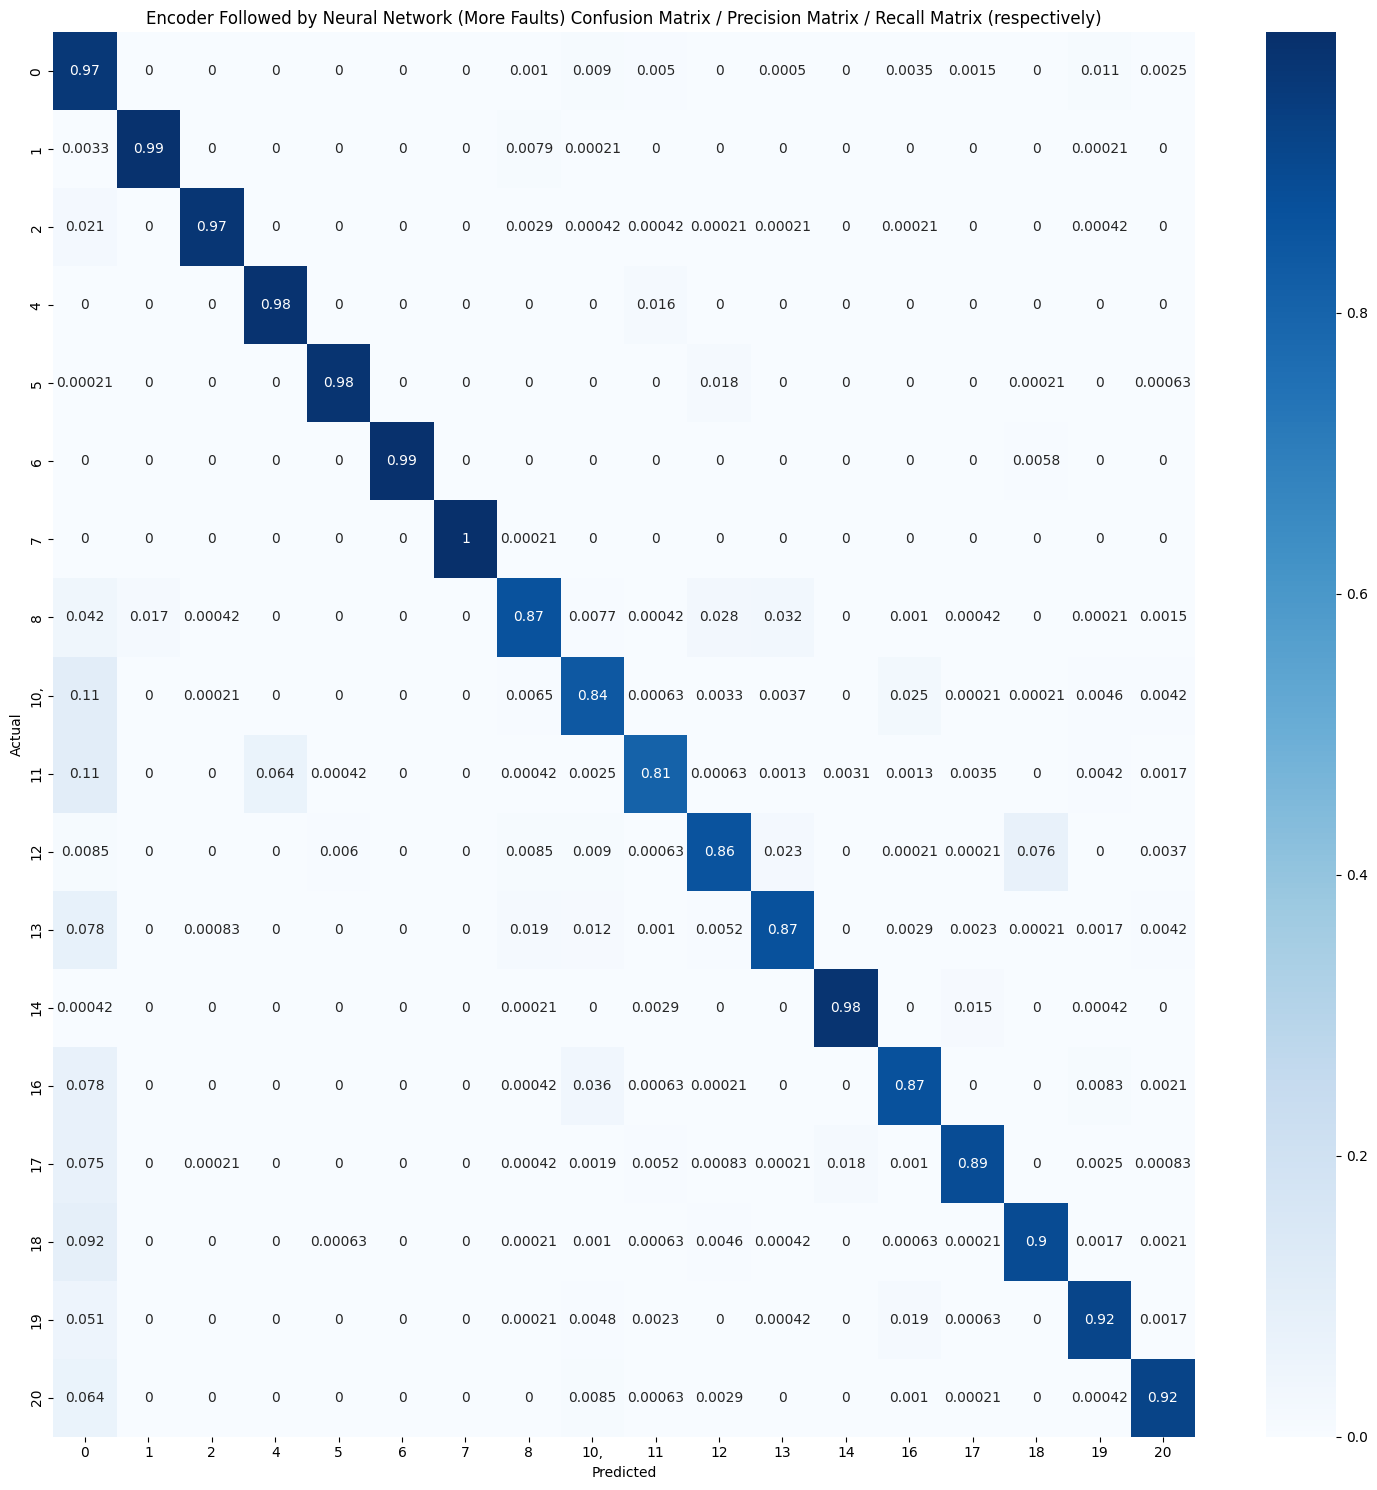

Aggregate Precision (including all classes): 0.928
Aggregate Precision (excluding class '0'): 0.962
Encoder followed by Neural Network (More Faults) 0.9226196172248804
Encoder followed by Neural Network (More Faults) f1 score micro: 0.9226196172248804
Encoder followed by Neural Network (More Faults) f1 score macro: 0.9172302548496231
Encoder followed by Neural Network (More Faults) f1 score weighted: 0.9305518994248557
Encoder followed by Neural Network (More Faults) f1 score none: [0.51948401 0.98556144 0.98629559 0.96114727 0.98679522 0.9970748
 0.99989582 0.90693629 0.87359793 0.87792737 0.89645482 0.90207907
 0.97980849 0.90749946 0.93220339 0.90554912 0.94409407 0.94774042]


In [124]:
plot_confusion_matrix_1(y_true, y_pred_1, 'Encoder Followed by Neural Network (More Faults) Confusion Matrix / Precision Matrix / Recall Matrix (respectively)')
print("Encoder followed by Neural Network (More Faults)", accuracy_score(y_true, y_pred_1))

from sklearn.metrics import f1_score

# Option 1: Use 'micro' average
print("Encoder followed by Neural Network (More Faults) f1 score micro:", f1_score(y_true, y_pred_1, average='micro'))

# Option 2: Use 'macro' average
print("Encoder followed by Neural Network (More Faults) f1 score macro:", f1_score(y_true, y_pred_1, average='macro'))

# Option 3: Use 'weighted' average
print("Encoder followed by Neural Network (More Faults) f1 score weighted:", f1_score(y_true, y_pred_1, average='weighted'))

# Option 4: Get F1 score for each class (No average)
print("Encoder followed by Neural Network (More Faults) f1 score none:", f1_score(y_true, y_pred_1, average=None))